# Efeito das GLOs no desmatamento

#### A partir de dados de alerta de desmatamento do Deter para os municípios

O objetivo deste trabalho é fazer uma comparação entre municípios teste (que receberam GLOs) e controle (que não receberam GLOs) para estimar, 
através do método de [Diferenças em Diferenças](https://en.wikipedia.org/wiki/Difference_in_differences), 
a eficácia das GLOs na redução do desmatamento.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import geopandas as gp
import re
import shap
from copy import copy
from scipy.optimize import minimize_scalar
from scipy.stats import binom
from matplotlib.patches import Patch

import xavy.explore as xe
import xavy.text as xt
import xavy.dataframes as xd
import xavy.utils as xu
import xavy.stats as xs
import xavy.causal as xc
import xavy.geo as xg
import xavy.mltools as ml

## Funções

In [2]:
def std_year(match):
    """
    Used to standardize dates like 
    '23/09/18' to '23/09/2018'.
    """
    string = match.group(1)
    return '/20' + string

def parse_date_series(series):
    """
    Parse dates in format '%d/%m/%y' or
    '%d/%m/%Y'.
    """
    return pd.to_datetime(series.str.replace(r'/(\d{2})$', std_year), format='%d/%m/%Y')

def concat_city_state(df, city_col, state_col):
    """
    Concatenate Series `df[city_col]` and `df[state_col]`.
    """
    
    return df[city_col] + ' - ' + df[state_col]

def gen_local_tag(df, city_col, state_col):
    """
    Generate a string Series identifying the locality
    in `df`, given by columns `city_col` and 
    `state_col`.
    """
    tag = concat_city_state(df, city_col, state_col)
    tag = tag.str.upper().apply(xt.remove_accents)
    return tag

In [3]:
def sel_mun_in_glo(df, glos_list):
    """
    Return data from `df` regarding municipalities 
    which received all GLOs in `glos_list` (list of 
    str).
    """
    slices = ['{} == "sim"'.format(glo) for glo in glos_list]
    query = ' and '.join(slices)
    sel = df.query(query)
    return sel

### Para ajuste de template

In [4]:
def scalar_model(par, model):
    """
    Return `model * par`, where `model`
    is a Series and `par` is a float.
    """
    return model * par

def linear_model(par, model):
    """
    Return `model + par`, where `model`
    is a Series and `par` is a float.
    """
    return model + par

def scalar_chi2(par, model, data):
    """
    Return the sum of the squares of 
    the residuals between `data` (Series) 
    and `par` (float) * `model` (Series).
    """
    return np.sum((data - scalar_model(par, model))**2)

def linear_chi2(par, model, data):
    """
    Return the sum of the squares of 
    the residuals between `data` (Series) 
    and `par` (float) + `model` (Series).
    """
    return np.sum((data - linear_model(par, model))**2)

### P/ diferenças em diferenças

In [5]:
def agg_alert_area(df, dt_col='month', area_col='areaMunKm'):
    """
    Sum the column `area_col` (str) of `df`
    (DataFrame) under groups defined by 
    `dt_col` (str) and return its mean.
    
    In other words, return the time-average 
    of the total alert area inside the 
    municipalities in `df`.
    """
    return df.groupby(dt_col)[area_col].sum().mean()


def frac_var(before_df, after_df, dt_col='month', area_col='areaMunKm'):
    """
    Compute the fraction between the average 
    total alert area in `after_df` and `before_df`.
    """
    return agg_alert_area(after_df, dt_col, area_col) / agg_alert_area(before_df, dt_col, area_col)


def ratio_in_ratios(ctrl_before_df, ctrl_after_df, test_before_df, test_after_df):
    """
    Compute the ratio between two ratios:
    - After and before treatment date in the 
      treatment group;
    - After and before treatment date in the 
      control group;
      
    Each input is a DataFrame with the area of
    Deter alerts at each date and municipality.
    """
    return frac_var(test_before_df, test_after_df) / frac_var(ctrl_before_df, ctrl_after_df)


def test_ratio_in_ratios(df, before_date, after_date, group_col='glo', date_col='month'):
    """
    Split the data in `df` by test and control group
    and by date (before and after treatment) and 
    perform a ratio in ratios test.  
    
    Parameters
    ----------
    df: DataFrame
        Alert areas per municipality and date.
    before_date : datetime or str
        Upper limit to select data before the 
        treatment (exclusive).
    after_date : datetime or str
        Lower limit to select data after the 
        treatment (exclusive).
    group_col : str
        Column in `df` that specifies if the
        data belongs to the test (1) or control
        (0) group.
    date_col : str
        Column in `df` that specifies the date
        of the data.
    
    Returns
    -------
    ratio : float
        The ratio between the ratios between 
        after and before treatment dates for
        the test and control groups.
    """
    
    ctrl_before_df = df.loc[(df[group_col] == 0) & (df[date_col] < before_date)]
    ctrl_after_df  = df.loc[(df[group_col] == 0) & (df[date_col] > after_date)]
    test_before_df = df.loc[(df[group_col] == 1) & (df[date_col] < before_date)]
    test_after_df  = df.loc[(df[group_col] == 1) & (df[date_col] > after_date)]

    return ratio_in_ratios(ctrl_before_df, ctrl_after_df, test_before_df, test_after_df)

In [6]:
def mean_desmate_in_period(df, dt1, dt2, name):
    """
    Compute the average monthly deflorestation 
    alert inside the specified time interval 
    for each municipality.
    
    Parameters
    ----------
    df : DataFrame
        Monthly deflorestation area alerts for
        all municipalities; has the columns 
        'month', 'tag' and 'areaMunKm'.
    dt1 : datetime or str ('%Y-%m-%d')
        First month of the time interval, 
        inclusive.
    dt2 : datetime or str ('%Y%m%d')
        Last month of the time interval,
        exclusive.
    
    Returns
    -------
    series : Series
        Average alert area for each 
        municipality.
    """
    series = df.loc[(df['month'] >= dt1) & (df['month'] < dt2)].groupby('tag')['areaMunKm'].mean()
    series.name = name
    return series

In [7]:
def max_desmate_in_period(df, dt1, dt2, name):
    """
    Compute the maximum monthly deflorestation 
    alert inside the specified time interval 
    for each municipality.
    
    Parameters
    ----------
    df : DataFrame
        Monthly deflorestation area alerts for
        all municipalities; has the columns 
        'month', 'tag' and 'areaMunKm'.
    dt1 : datetime or str ('%Y-%m-%d')
        First month of the time interval, 
        inclusive.
    dt2 : datetime or str ('%Y%m%d')
        Last month of the time interval,
        exclusive.
    
    Returns
    -------
    series : Series
        Average alert area for each 
        municipality.
    """
    series = df.loc[(df['month'] >= dt1) & (df['month'] < dt2)].groupby('tag')['areaMunKm'].max()
    series.name = name
    return series

In [8]:
def agg_random_area_alert(df, n_join_mun=114):
    """
    Randomly select `n_join_mun` municipalities 
    from `df` and sum their alerts for each month.
    
    `df` is expected to have the columns:
    'tag', 'month' and 'areaMunKm'.
    """
    
    # Select list of municipalities:
    mun_series = df['tag'].drop_duplicates()
    
    # Sum the alerts for a random area:
    random_area_alert = df.loc[df['tag'].isin(mun_series.sample(n_join_mun))].groupby('month')['areaMunKm'].sum()
    
    return random_area_alert

In [9]:
def compute_fit(y, y_template):
    """
    Fit a template to data by scaling it.
    
    Parameters
    ----------
    y : Series
        Data to be fitted.
    y_template : Series
        Data template to be fitted
        by multiplying it by a factor.
    
    Returns
    -------
    y_model : Series
        The scaled template that minimizes
        the sum of the squares of the 
        residuals.
    """
    min_scalar_model = minimize_scalar(scalar_chi2, args=(y_template, y))
    y_model = scalar_model(min_scalar_model.x, y_template)
    return y_model

def compute_residuals(y, y_template):
    """
    Compute the residuals between a 
    scaled template and data.

    Parameters
    ----------
    y : Series
        Data to be fitted.
    y_template : Series
        Data template to be fitted
        by multiplying it by a factor.
    
    Returns
    -------
    residuals : Series
        Difference between the data and 
        the scaled template that minimizes
        the sum of the squares of the 
        residuals.
    """
    y_model = compute_fit(y, y_template)
    return (y - y_model)

In [10]:
def compute_residuals_4all(monthly_area_glo_df):
    """
    Compute the residuals from the average 
    deflarestation alert area time series 
    for all municipalities.
    
    Parameters
    ----------
    monthly_area_glo_df : DataFrame
        One row per municipality and month.
        Columns expected: 'tag', 'month', 
        'areaMunKm'.
    
    Returns
    -------
    df : DataFrame
        DataFrame with the residuals between
        the municipality's alert area time 
        series and the average monthly alert 
        area (average computed over the 
        municipalities). Other columns are 
        'tag' and 'month'.        
    """
    
    # Cria template para municípios:
    deter_template = monthly_area_glo_df.groupby('month')['areaMunKm'].mean()
    
    # LOOP sobre municípios:
    df_list = []
    mun_all = sorted(monthly_area_glo_df['tag'].unique())
    for tag in mun_all:

        # Calcula resíduos para um município:
        residuos = compute_residuals(monthly_area_glo_df.loc[monthly_area_glo_df['tag'] == tag].set_index('month')['areaMunKm'], deter_template)
        residuos.name = 'residuo'

        # Cria DataFrame com dados do município:
        df = residuos.reset_index()
        df['tag'] = tag

        # Adiciona o DataFrame à lista:
        df_list.append(df)

    df = pd.concat(df_list, ignore_index=True)
    return df

In [11]:
def list_extreme_alert_places(monthly_residuals_df, date, n_places):
    """
    Return a set of municipalities with 
    largest alert areas residuals.
    
    Parameters
    ----------
    monthly_residuals_df : DataFrame
        Residuals por month and municipality.
    date : str or datetime
        Date in format '%Y-%m-%d' where to look
        for the highest residuals.
    n_places : int
        Number of municipalities to return.
    
    Returns
    -------
    extreme : set
        `n_places` municipalities with the 
        largest residuals in month `date`.
    """
    return set(monthly_residuals_df.loc[monthly_residuals_df['month'] == date].sort_values('residuo', ascending=False)['tag'].iloc[:n_places])

## Carregando e preparando os dados

### Mapa dos municípios brasileiros

In [12]:
mun_gdf = gp.read_file('../dados/mapas/municipalities_legal_amazon/municipalities_legal_amazon.shp')
mun_gdf['cod_ibge'] = mun_gdf['cod_ibge'].astype(int)

### Dados das GLOs

Os dados abaixo foram tabelados a partir da resposta ao [RIC 1147/2021](https://www.camara.leg.br/proposicoesWeb/fichadetramitacao?idProposicao=2298361).

In [13]:
# Dados da execução de GLOs:
mun_glos_df = pd.read_csv('../dados/brutos/outros/municipios_com_glos.csv')
mun_glos_df['verde_brasil_1_inicio'] = parse_date_series(mun_glos_df['verde_brasil_1_inicio'])
mun_glos_df['verde_brasil_1_final']  = parse_date_series(mun_glos_df['verde_brasil_1_final'])
mun_glos_df['verde_brasil_2_inicio'] = parse_date_series(mun_glos_df['verde_brasil_2_inicio'])
mun_glos_df['verde_brasil_2_final']  = parse_date_series(mun_glos_df['verde_brasil_2_final'])
mun_glos_df['samauma_inicio'] = parse_date_series(mun_glos_df['samauma_inicio'])
mun_glos_df['samauma_final']  = parse_date_series(mun_glos_df['samauma_final'])
mun_glos_df['tag'] = gen_local_tag(mun_glos_df, 'Municipio', 'Estado')

Já estes foram construídos em análises documentadas em notebooks anteriores, a partir de [dados do Prodes](http://terrabrasilis.dpi.inpe.br/app/dashboard/deforestation/biomes/legal_amazon/rates).

In [14]:
# Área florestal (i.e. desmatável) dos municípios:
area_florestal_df = pd.read_csv('../dados/processed/prodes_codIbge_municipios_area-florestal.csv').set_index('CodIbge')

# Junta aos dados de GLOs: 
mun_glos_area_df = mun_glos_df.join(area_florestal_df, on='CodIbge')
assert len(mun_glos_area_df) == len(mun_glos_df)

In [15]:
print('Data da primeira GLO:', mun_glos_df['verde_brasil_1_inicio'].min().date())

Data da primeira GLO: 2019-08-24


### Dados de desmatamento

Os dados abaixo foram obtidos do [Dashboard de avisos do Deter](http://terrabrasilis.dpi.inpe.br/app/dashboard/alerts/legal/amazon/daily), no site TerraBrasilis.

In [16]:
# Dados diários e municipais:
deter_diario_df = pd.read_csv('../dados/brutos/desmatamento/terrabrasilis_deter/deter_desmatamento_diario_2016-01-01_2022-05-06.csv')
deter_diario_df['viewDate']    = pd.to_datetime(deter_diario_df['viewDate'], format='%m/%d/%Y')
deter_diario_df['year']        = deter_diario_df['viewDate'].dt.year
deter_diario_df['month']       = deter_diario_df['viewDate'].dt.month
deter_diario_df['month_date']  = pd.to_datetime(deter_diario_df['year'].astype(str) + deter_diario_df['month'].astype(str).str.zfill(2) + '01', format='%Y%m%d')
deter_diario_df['tag']         = gen_local_tag(deter_diario_df, 'municipio', 'uf')
#deter_diario_df['shift_year']  = (deter_diario_df['viewDate'] - pd.DateOffset(days=15)).dt.year
#deter_diario_df['shift_month'] = (deter_diario_df['viewDate'] - pd.DateOffset(days=15)).dt.month
#deter_diario_df['shift_month_date'] = pd.to_datetime(deter_diario_df['shift_year'].astype(str) + deter_diario_df['shift_month'].astype(str).str.zfill(2) + '01', format='%Y%m%d') # Mês de 15 dias antes.

# Remove dados sem municípios (os casos existentes têm área de alerta zero, de qualquer forma):
diario_cleaned_df = deter_diario_df.loc[~deter_diario_df['municipio'].isnull()]

In [17]:
# Agrega por mês:
mensal_cleaned_df = diario_cleaned_df.groupby(['tag', 'month_date'])['areaMunKm'].sum().reset_index().sort_values(['tag', 'month_date'])
# Joga fora o último mês que está incompleto:
mensal_cleaned_df = mensal_cleaned_df.loc[mensal_cleaned_df['month_date'] < mensal_cleaned_df['month_date'].max()]

### Junta os dados

In [18]:
# Make sure standardizing locality names does not create overlaps:
assert len(set(gen_local_tag(mun_glos_df, 'Municipio', 'Estado'))) == len(set(concat_city_state(mun_glos_df, 'Municipio', 'Estado')))
assert len(set(gen_local_tag(deter_diario_df, 'municipio', 'uf'))) == len(set(concat_city_state(deter_diario_df, 'municipio', 'uf')))

In [19]:
# Cria base de desmatamento com todos os meses e municípios:
date_interval = xu.date_range(mensal_cleaned_df['month_date'].min(), mensal_cleaned_df['month_date'].max(), freq='M')
complete_mun_date_df = pd.DataFrame({'tag': xd.prepare_series_for_cross_join(mun_glos_df['tag'])})
complete_mun_date_df = complete_mun_date_df.join(pd.Series(date_interval, index=[0]*len(date_interval), name='month')).reset_index(drop=True)
complete_area_df = complete_mun_date_df.join(mensal_cleaned_df.set_index(['tag', 'month_date'])['areaMunKm'], on=['tag', 'month'])
# Dados faltantes são considerados com desmatamento zero:
complete_area_df.fillna(0, inplace=True)

### Identificando grupos teste e controle

A operação Samauma foi muito recente, o que reduz o tamanho do período pós-tratamento (i.e. pós GLOs). Para termos um período pós tratamento maior, vamos ignorar os municípios que receberam a operação Samauma (tanto como teste quanto como controle) e vamos considerar apenas as operações Verde Brasil 1 e Verde Brasil 2.

In [20]:
# Ignorando Samauma:
mun_controle = set(mun_glos_df.loc[  mun_glos_df['verde_brasil_1'].isnull() & mun_glos_df['verde_brasil_2'].isnull() & mun_glos_df['samauma'].isnull(), 'tag'])
mun_teste    = set(mun_glos_df.loc[~(mun_glos_df['verde_brasil_1'].isnull() & mun_glos_df['verde_brasil_2'].isnull()) & mun_glos_df['samauma'].isnull(), 'tag'])

# Incluindo Samauma:
#mun_controle = set(mun_glos_df.loc[  mun_glos_df['verde_brasil_1'].isnull() & mun_glos_df['verde_brasil_2'].isnull() & mun_glos_df['samauma'].isnull(), 'tag'])
#mun_teste    = set(mun_glos_df.loc[~(mun_glos_df['verde_brasil_1'].isnull() & mun_glos_df['verde_brasil_2'].isnull() & mun_glos_df['samauma'].isnull()), 'tag'])

n_controle = len(mun_controle)
n_teste    = len(mun_teste)
print(xe.bold('Número de municípios'))
print('# s/ GLO: {}   # c/ GLO: {}'.format(n_controle, n_teste))

Número de municípios
# s/ GLO: 619   # c/ GLO: 114


In [21]:
# GLOs a serem consideradas:
glos_inicio_cols = ['verde_brasil_1_inicio', 'verde_brasil_2_inicio']
glos_final_cols  = ['verde_brasil_1_final', 'verde_brasil_2_final']
#glos_inicio_cols = ['verde_brasil_1_inicio', 'verde_brasil_2_inicio', 'samauma_inicio']
#glos_final_cols  = ['verde_brasil_1_final', 'verde_brasil_2_final', 'samauma_final']

# Meses de início de de término das GLOs em cada município:
glo_first_month = xd.date_series_replace(mun_glos_df.set_index('tag')[glos_inicio_cols].min(axis=1), day=1)
glo_first_month.name = 'first_glo_month'
glo_last_month  = xd.date_series_replace(mun_glos_df.set_index('tag')[glos_final_cols].max(axis=1), day=1)
glo_last_month.name = 'last_glo_month'

# Cria coluna com indicador se é grupo teste (recebeu GLO) ou controle (não recebeu GLO):
monthly_area_glo_df = complete_area_df.copy()
monthly_area_glo_df['glo'] = np.NaN
monthly_area_glo_df.loc[monthly_area_glo_df['tag'].isin(mun_teste), 'glo'] = 1
monthly_area_glo_df.loc[monthly_area_glo_df['tag'].isin(mun_controle), 'glo'] = 0
# Elimina municípios que não são teste nem controle (Op. Samauma):
monthly_area_glo_df = monthly_area_glo_df.loc[~monthly_area_glo_df['glo'].isnull()]
monthly_area_glo_df['glo'] = monthly_area_glo_df['glo'].astype(int)

# Junta data de início e de término das GLOs:
monthly_area_glo_df = monthly_area_glo_df.join(glo_first_month, on='tag').join(glo_last_month, on='tag')

# Registra o estágio da GLO no município:
monthly_area_glo_df['glo_stage'] = np.NaN
monthly_area_glo_df.loc[monthly_area_glo_df['month'] < monthly_area_glo_df['first_glo_month'], 'glo_stage'] = 'antes'
monthly_area_glo_df.loc[monthly_area_glo_df['month'] > monthly_area_glo_df['last_glo_month'], 'glo_stage'] = 'depois'
monthly_area_glo_df.loc[(monthly_area_glo_df['month'] >= monthly_area_glo_df['first_glo_month']) & (monthly_area_glo_df['month'] <= monthly_area_glo_df['last_glo_month']), 'glo_stage'] = 'durante'

In [22]:
# Se certifica que os municípios estão agrupados de maneira correta:
assert (monthly_area_glo_df.loc[monthly_area_glo_df['tag'].isin(mun_teste), 'glo'] == 1).all()
assert (monthly_area_glo_df.loc[monthly_area_glo_df['tag'].isin(mun_controle), 'glo'] == 0).all()
assert set(monthly_area_glo_df.loc[monthly_area_glo_df['tag'].isin(mun_teste), 'tag']) == mun_teste
assert set(monthly_area_glo_df.loc[monthly_area_glo_df['tag'].isin(mun_controle), 'tag']) == mun_controle

# Certifica-se que o número de linhas é o esperado (dados dos municípios sem GLO Samaúma):
mun_sem_samauma = set(mun_glos_df.loc[mun_glos_df['samauma'].isnull(), 'tag'])
assert len(complete_area_df.loc[complete_area_df['tag'].isin(mun_sem_samauma)]) == len(monthly_area_glo_df)

## Visualizando a evolução do desmatamento

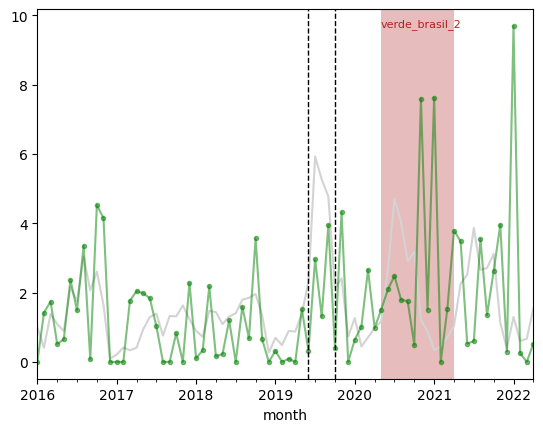

In [22]:
tag = list(mun_teste)[3]

# Série média e série do município:
mun_series = monthly_area_glo_df.loc[monthly_area_glo_df['tag'] == tag].set_index('month')['areaMunKm']
avg_series = monthly_area_glo_df.groupby('month')['areaMunKm'].mean()
# Desmatamento médio:
mun_avg        = mun_series.mean()
avg_series_avg = avg_series.mean()

# Plots das áreas de alerta:
(avg_series / avg_series_avg * mun_avg).plot(color='lightgray')
mun_series.plot(marker='.', alpha=0.5, color='g')

# Atuação das GLOs:
mun_info = mun_glos_df.loc[mun_glos_df['tag'] == tag].iloc[0]
for op in ['verde_brasil_1', 'verde_brasil_2', 'samauma']:
    if mun_info[op] == 'sim':
        pl.axvspan(mun_info[op + '_inicio'], mun_info[op + '_final'], facecolor='firebrick', alpha=0.3, edgecolor='none')
        pl.text(pd.Series([mun_info[op + '_inicio'], mun_info[op + '_final']]).mean(), mun_series.max(), op, ha='center', color='firebrick', fontsize=8)

pl.axvline(pd.to_datetime('2019-06-01'), color='k', linewidth=1, linestyle='--')
pl.axvline(pd.to_datetime('2019-10-01'), color='k', linewidth=1, linestyle='--')
pl.show()

## Seleção de alvos de GLOs

Vamos ajustar um modelo de classificação de municípios em GLOs e não GLOs a partir dos alertas anteriores às GLOs.

In [22]:
# Seleciona datas relevantes:
first_data_month    = monthly_area_glo_df['month'].min()
no_glo_date         = monthly_area_glo_df['first_glo_month'].min()
last_data_month     = xd.date_series_replace(pd.Series([monthly_area_glo_df['month'].max() + pd.DateOffset(days=32)]), day=1).iloc[0]
bolsonaro_start     = pd.to_datetime('2019-01-01')
avg_glo_effect_date = pd.to_datetime('2020-11-01')
#end_glo_date        = pd.to_datetime('2021-09-01')
end_glo_date        = pd.to_datetime('2021-03-01')
phase_dates = [first_data_month, bolsonaro_start, no_glo_date, end_glo_date, last_data_month]
phase_names = ['hist', 'pre', 'durante', 'pos']

### Preparação dos dados

In [23]:
features = monthly_area_glo_df.loc[monthly_area_glo_df['month'] < no_glo_date].pivot(index='tag', columns='month', values='areaMunKm')
target   = monthly_area_glo_df.drop_duplicates('tag').set_index('tag')['glo']
class_df = features.join(target)

In [24]:
class_train_df, class_test_df = ml.random_set_split(class_df, [0.8, 0.2], 4314)
class_X_train, class_y_train = ml.Xy_split(class_train_df, 'glo')
class_X_test, class_y_test = ml.Xy_split(class_test_df, 'glo')

### Classificação

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, get_scorer, make_scorer
import shap

In [26]:
classifier = LogisticRegression(C=1e-5, max_iter=1000)
#classifier = RandomForestClassifier(class_weight={1:2, 0:1}, max_features='log2', max_depth=8, min_samples_split=8)

In [27]:
# Find best-hyperparameters:
param_grid = {'C': [1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]}
#param_grid = {'max_depth': [2, 4, 8, 16, 32, 64, None], 'min_samples_split': [2, 4, 8, 16, 32], 'max_features': [None, 'sqrt', 'log2'], 'class_weight': [{1:4.4, 0:1}, {1:2, 0:1}, {1:8, 0:1}, {1:1, 0:1}]}
grid = GridSearchCV(classifier, param_grid, scoring='roc_auc', return_train_score=True, n_jobs=7)

In [30]:
dump = grid.fit(class_X_train, class_y_train)

FixedFormatter should only be used together with FixedLocator


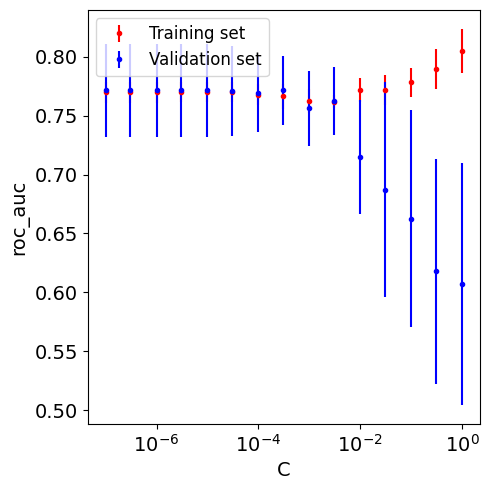

In [31]:
ml.plot_pars_scores(grid)
pl.show()

In [32]:
ml.print_cv_scores(classifier, class_X_train, class_y_train, ['roc_auc', 'accuracy', 'precision', 'recall'])

roc_auc: 0.7714 +/- 0.0176
accuracy: 0.8430 +/- 0.0017


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


precision: 0.0000 +/- 0.0000
recall: 0.0000 +/- 0.0000


### Resultado para um modelo linear

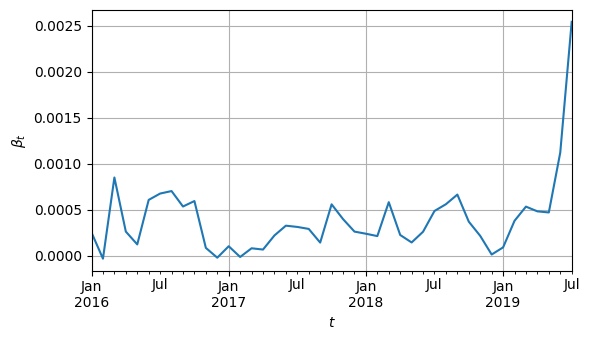

In [133]:
# Importância do desmatamento em cada época

#dump = classifier.fit(class_X_train, class_y_train[ml.shuffled_pos(len(class_y_train), 1535)])
dump = classifier.fit(class_X_train, class_y_train)
pl.figure(figsize=(6,3.5))
logistic_coefs = pd.Series(classifier.coef_[0], index=class_X_train.columns)
logistic_coefs.plot()
pl.grid()
pl.ylabel(r'$\beta_t$')
pl.xlabel('$t$')
pl.tight_layout()
#pl.savefig('../resultados/plots/coefs_logistic_regression_GLO_classifier.png')
pl.show()

### Evidências de seleção de municípios desviantes

In [116]:
# Calcula template:
n_mun_join = len(mun_teste)
deter_template = monthly_area_glo_df.groupby('month')['areaMunKm'].mean() * n_mun_join

In [117]:
# Calcula resíduo do modelo para a região com GLOs:
glo_series = monthly_area_glo_df.query('glo == 1').groupby('month')['areaMunKm'].sum()
glo_residuals = compute_residuals(glo_series, deter_template)
glo_residuals.name = 'glo'

# Calcula resíduo para diversas amostras aleatórias:
n_samples=10000
rand_resid_df = pd.DataFrame({i: compute_residuals(agg_random_area_alert(monthly_area_glo_df, n_mun_join), deter_template) for i in range(n_samples)})

# Calcula valor p dos resíduos da região c/ GLOs:
glo_resid_pvalues = (rand_resid_df.transpose() > glo_residuals).astype(float).mean()
significance_level = 0.05 / len(glo_series)

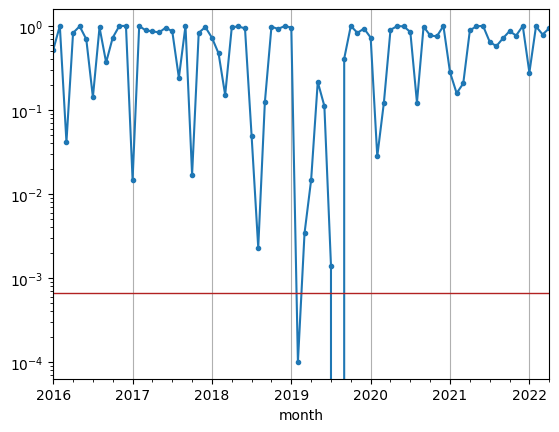

In [118]:
# Plot dos valores p para cada mês:
glo_resid_pvalues.plot(marker='.')
pl.yscale('log')
pl.grid(axis='x')
pl.axhline(significance_level, color='firebrick', linewidth=1)
pl.show()

Vemos acima que a amostra de municípios com GLOs apresenta resíduos muito maiores que os esperados por uma seleção aleatória de municípios. Ou seja: essa amostra foi selecionada especificamente por possuir resíduos acima do esperado.

In [119]:
# Calcula médio e desv. pad. dos resíduos aleatórios:
mean_resid_series = rand_resid_df.mean(axis=1)
dev_resid_series  = rand_resid_df.std(axis=1)

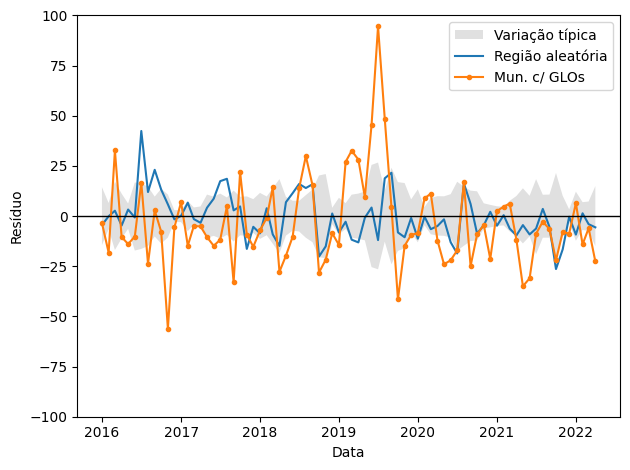

In [120]:

pl.fill_between(mean_resid_series.index, mean_resid_series - dev_resid_series, mean_resid_series + dev_resid_series, 
                facecolor='lightgray', alpha=0.7, edgecolor='none', label='Variação típica')
region_series = agg_random_area_alert(monthly_area_glo_df, n_mun_join)
pl.plot(region_series.index, compute_residuals(region_series, deter_template), label='Região aleatória')
pl.plot(glo_series.index, glo_residuals, label='Mun. c/ GLOs', marker='.')
pl.axhline(0, linewidth=1, color='k')
pl.ylim([-100, 100])
pl.xlabel('Data')
pl.ylabel('Resíduo')
pl.legend()
pl.tight_layout()
#pl.savefig('../resultados/plots/residuos_glo_vs_outros_municipios.png')
pl.show()

## Modelos causais

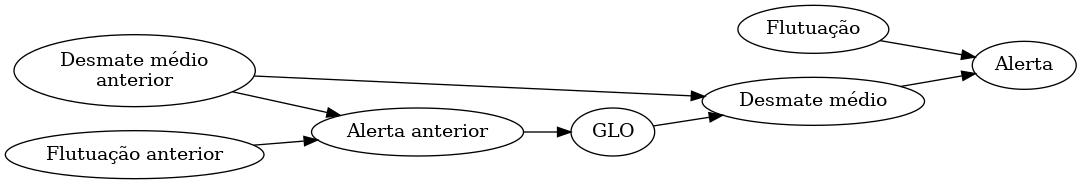

In [385]:
xc.plot_diagram([('GLO', 'Desmate médio'), ('Desmate médio', 'Alerta'), ('Desmate médio\nanterior', 'Alerta anterior'), ('Alerta anterior', 'GLO'),
                 ('Desmate médio\nanterior', 'Desmate médio'), ('Flutuação anterior', 'Alerta anterior'), ('Flutuação', 'Alerta')])

### Modelo 0

In [134]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#### Preparação dos dados

In [135]:
# Montagem dos dados:
data_series = [mean_desmate_in_period(monthly_area_glo_df, dt1, dt2, name) for dt1, dt2, name in zip(phase_dates[:-1], phase_dates[1:], phase_names)]
model_data_df = pd.DataFrame(data_series).transpose()
model_data_df['florestal'] = mun_glos_area_df.set_index('tag')['Desmatavel']
model_data_df['glo'] = monthly_area_glo_df[['tag', 'glo']].drop_duplicates().set_index('tag')['glo']
model_data_df['incremento'] = model_data_df['pre'] - model_data_df['hist']
alertas = ['hist', 'pre', 'durante', 'pos']
for c in alertas:
    model_data_df[c + '_frac'] = (model_data_df[c] / model_data_df['florestal'] * 1e4).fillna(0)

In [136]:
# Separação em treino e teste:
train_df, test_df = ml.random_set_split(model_data_df, [0.8, 0.2], 67099)
#X_train, y_train = ml.Xy_split(train_df, 'pos')
#X_test, y_test   = ml.Xy_split(test_df, 'pos')
X_train, y_train = ml.Xy_split(train_df, 'pos_frac')
X_test, y_test   = ml.Xy_split(test_df, 'pos_frac')
X_train = X_train.drop(columns=alertas + ['durante_frac', 'florestal'])#.drop(columns=['durante', 'pre', 'glo'])
X_test  = X_test.drop(columns=alertas + ['durante_frac', 'florestal'])#.drop(columns=['durante', 'pre', 'glo'])
#X_train = X_train.drop(columns=['durante'])#.drop(columns=['durante', 'pre', 'glo'])
#X_test  = X_test.drop(columns=['durante'])#.drop(columns=['durante', 'pre', 'glo'])

In [137]:
# Performance básica:
y_train.std()

1.385172380629375

In [21]:
# Cria modelo:
#model = RandomForestRegressor()
model = DecisionTreeRegressor()
#model = LinearRegression()
#model = Ridge()
#model = Pipeline([('poly', PolynomialFeatures(degree=1)), ('proc', StandardScaler()), ('fit', LinearRegression(fit_intercept=False))])
#model = Pipeline([('poly', PolynomialFeatures(degree=2)), ('proc', StandardScaler()), ('fit', Ridge(fit_intercept=False))])

In [22]:
#param_grid = {'poly__degree': [1, 2, 3, 4],
#              'fit__alpha': [1.0, 3.0, 10., 30., 100.]}
param_grid = {'fit__fit_intercept': [True, False],
              'proc__with_mean': [True, False],
              'proc__with_std': [True, False],
              'poly__degree': [1, 2]}
param_grid = {'fit_intercept': [True, False]}
param_grid = {'n_estimators': [100, 400]}
param_grid = {'max_depth': [2,4,8,16,32], 
              'min_samples_split': [2, 4, 8, 16, 32, 64]}
#param_grid = {'alpha': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10., 30., 100.]}
grid = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', return_train_score=True)
dump = grid.fit(X_train, y_train)

In [23]:
#ml.plot_pars_scores(grid)
#pl.show()

In [25]:
ml.searchCV_table(grid)

,mean_fit_time,std_fit_time,param_max_depth,param_min_samples_split,mean_test_score,std_test_score,mean_train_score,std_train_score
9,0.002099,0.000077,4,16,-0.972395,0.106444,-0.729425,0.039574
10,0.002088,0.000060,4,32,-0.978862,0.123418,-0.874806,0.064670
11,0.002113,0.000155,4,64,-0.980700,0.128898,-0.897123,0.061958
17,0.002236,0.000027,8,64,-0.981690,0.127893,-0.893829,0.060181
23,0.002161,0.000073,16,64,-0.981703,0.127878,-0.893827,0.060180
29,0.002228,0.000067,32,64,-0.981703,0.127878,-0.893827,0.060180
28,0.002576,0.000659,32,32,-0.985639,0.117244,-0.842714,0.058319
22,0.002450,0.000172,16,32,-0.985639,0.117244,-0.842714,0.058319
16,0.002350,0.000027,8,32,-0.986119,0.117990,-0.844713,0.057227
1,0.004356,0.003909,2,4,-0.986876,0.145228,-0.873065,0.026175


In [314]:
best_model = grid.best_estimator_
best_model.coef_

array([-0.04621081,  0.0440263 ,  0.45590037])

## Diferenças em diferenças entre áreas totais

In [44]:
# Definição das datas:
start_date  = '2016-04-01' # Começo do período pré-tratamento (inclusive).
before_date = '2019-04-01' # Final do período pré-tratamento (exclusive).
after_date  = '2021-04-01' # Começo do período pós-tratamento (exclusive).
end_date    = '2022-04-01' # Final do período pós-tratamento (inclusive).

# Seleção dos dados:
rir_df = monthly_area_glo_df.loc[(monthly_area_glo_df['month'] >= start_date) & (monthly_area_glo_df['month'] <= end_date)]

# Cria base de municípios sem GLOs e Série de labels sintéticos de GLO.
ctrl_only_df = rir_df.loc[rir_df['glo'] == 0]
ctrl_glo = pd.Series(np.zeros(ctrl_only_df['tag'].nunique()), index=ctrl_only_df['tag'].unique(), dtype=int, name='glo')
ctrl_glo.iloc[:n_teste] = 1

In [45]:
# Bootstraping do teste Dif in Dif:
n_samples = 10000
mun_glo_bool = rir_df.drop_duplicates(['tag', 'glo']).set_index('tag')['glo']
#rir_sample = np.array([test_ratio_in_ratios(rir_df.drop(columns='glo').join(xs.shuffle_data(mun_glo_bool), on='tag'), before_date, after_date) for _ in range(n_samples)])
rir_sample = np.array([test_ratio_in_ratios(ctrl_only_df.drop(columns='glo').join(xs.shuffle_data(ctrl_glo), on='tag'), before_date, after_date) for _ in range(n_samples)])

# Medida Dif. in Dif. para os dados reais:
rir_full_t = test_ratio_in_ratios(rir_df, before_date, after_date)
rir_pvalue = 1 - xs.p_value(rir_sample, rir_full_t)

In [46]:
print('Para a redução ser estatisticamente significativa, precisaria ser de, no mínimo, {:.1f}%.'.format(pd.Series(rir_sample - 1).sort_values().iloc[int(n_samples * 0.05)] * 100))

Para a redução ser estatisticamente significativa, precisaria ser de, no mínimo, -29.2%.


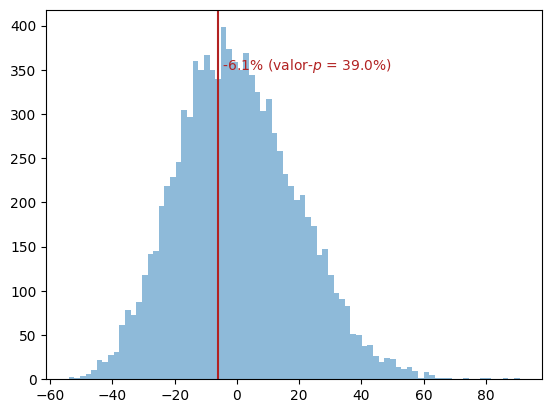

In [47]:
pl.hist((rir_sample - 1) * 100, bins=80, alpha=0.5)
pl.axvline((rir_full_t - 1) * 100, color='firebrick')
pl.text((rir_full_t - 1) * 100, 350, ' {:.1f}% (valor-$p$ = {:.1f}%)'.format((rir_full_t - 1) * 100, rir_pvalue * 100), color='firebrick', fontsize=10)
pl.xlabel('')
pl.show()

In [48]:
def yearly_average(df):
    """
    Given a DataFrame `df` with the same
    structure as `monthly_area_glo_df`, 
    compute average yearly alert area.
    """
    monthly_rate = df.groupby('month')['areaMunKm'].sum()
    result = monthly_rate.sum() / len(monthly_rate) * 12
    return result

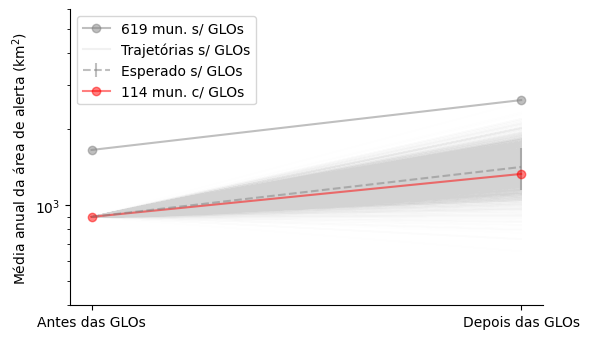

In [53]:
# Gráfico clássico das diferenças em diferenças:

ctrl_0 = yearly_average(rir_df.loc[(rir_df['glo'] == 0) & (rir_df['month'] < before_date)])
ctrl_1 = yearly_average(rir_df.loc[(rir_df['glo'] == 0) & (rir_df['month'] > after_date)])
test_0 = yearly_average(rir_df.loc[(rir_df['glo'] == 1) & (rir_df['month'] < before_date)])
test_1 = yearly_average(rir_df.loc[(rir_df['glo'] == 1) & (rir_df['month'] > after_date)])

years = ['Antes das GLOs', 'Depois das GLOs']
pl.figure(figsize=(6,3.5))
# Ctrl:
pl.plot(years, [ctrl_0, ctrl_1], marker='o', alpha=0.5, color='gray', label='{} mun. s/ GLOs'.format(len(mun_controle)))
# Ctrl samples:
n_sample_lines = 2000
for z in rir_sample[:n_sample_lines]:
    pl.plot(years, 10**(np.log10([ctrl_0, ctrl_1]) - np.log10(ctrl_0) + np.log10(test_0) + np.log10([1, z])), alpha=0.005, color='lightgray')
pl.plot(years, 10**(np.log10([ctrl_0, ctrl_1]) - np.log10(ctrl_0) + np.log10(test_0) + np.log10([1, rir_sample[n_sample_lines]])), alpha=0.3, color='lightgray', label='Trajetórias s/ GLOs')
# Expectation:
pl.errorbar(years, 10**(np.log10([ctrl_0, ctrl_1]) - np.log10(ctrl_0) + np.log10(test_0)), color='gray', linestyle='--', yerr=[0, np.std(ctrl_1/ctrl_0*test_0*rir_sample)], alpha=0.5, label='Esperado s/ GLOs')
# Test:
pl.plot(years, [test_0, test_1], marker='o', alpha=0.5, color='r', label='{} mun. c/ GLOs'.format(len(mun_teste)))
# Format:
pl.yscale('log')
pl.ylabel('Média anual da área de alerta ($\mathrm{km^2}$)')
pl.ylim([400, 6e3])
ax = pl.gca()
handles, labels = ax.get_legend_handles_labels()
pl.legend(np.array(handles, dtype='object')[[0,1,3,2]], np.array(labels, dtype='object')[[0,1,3,2]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tight_layout()
#pl.savefig('../resultados/plots/diff-in-diff_alertas_deter.png')
pl.show()

### Identificação das datas de tratamento

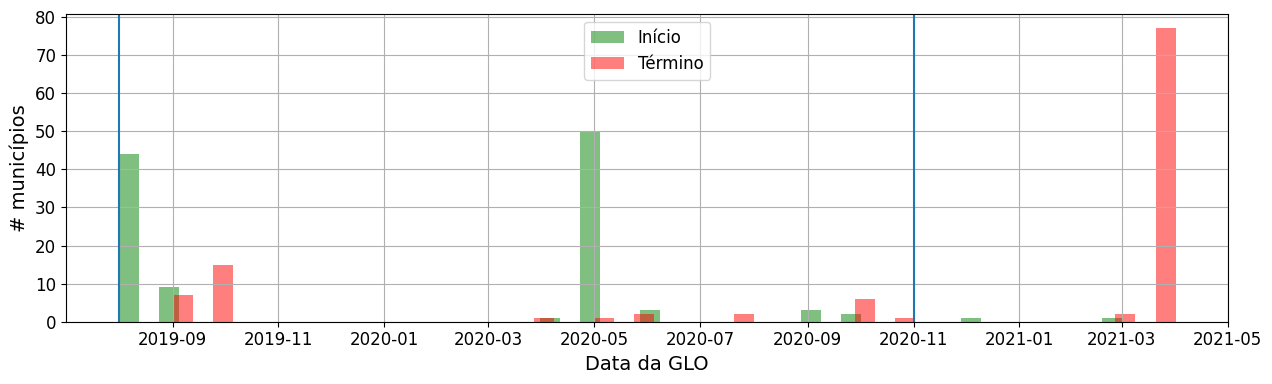

In [22]:
avg_glo_effect_date = pd.to_datetime('2020-11-01')
no_glo_date = monthly_area_glo_df['first_glo_month'].min()

pl.figure(figsize=(15,4))
monthly_area_glo_df.drop_duplicates(subset='tag')['first_glo_month'].hist(bins=50, label='Início', color='g', alpha=0.5)
monthly_area_glo_df.drop_duplicates(subset='tag')['last_glo_month'].hist(bins=50, label='Término', color='r', alpha=0.5)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)
pl.xlabel('Data da GLO', fontsize=14)
pl.ylabel('# municípios', fontsize=14)
pl.axvline(avg_glo_effect_date)
pl.axvline(no_glo_date)
pl.show()

### Análise pré-tratamento

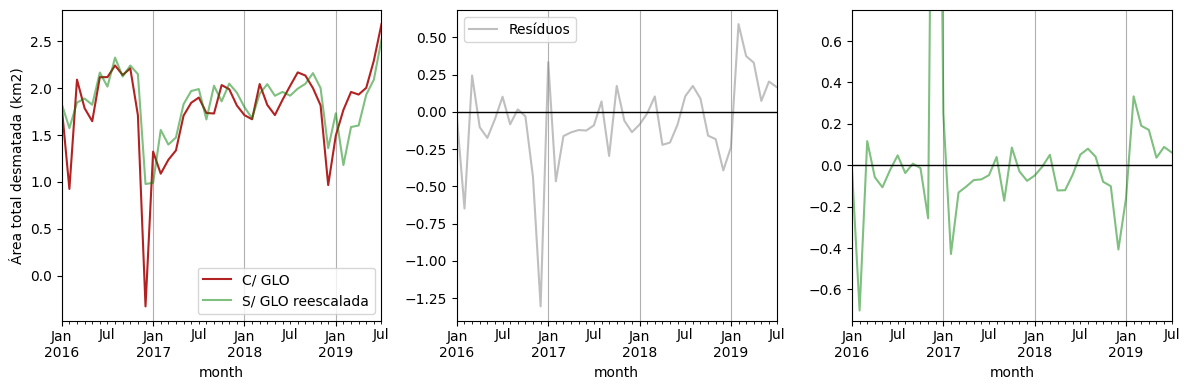

In [23]:
no_glo_date = monthly_area_glo_df['first_glo_month'].min()

pre_monthly_area_glo_df = monthly_area_glo_df.loc[monthly_area_glo_df['month'] < no_glo_date]
ctrl_series = pre_monthly_area_glo_df.query('glo == 0').groupby('month')['areaMunKm'].sum()
glo_series  = pre_monthly_area_glo_df.query('glo == 1').groupby('month')['areaMunKm'].sum()
log_shift   = glo_series.mean() / ctrl_series.mean()

pl.figure(figsize=(12,4))

pl.subplot(1,3,1)
#np.log10(ctrl_series).plot(label='S/ GLO', color='g') 
np.log10(glo_series).plot(label='C/ GLO', color='firebrick')
np.log10(ctrl_series * log_shift).plot(label='S/ GLO reescalada', color='g', alpha=0.5)

pl.ylabel('Área total desmatada (km2)')
pl.axvline(monthly_area_glo_df['first_glo_month'].min(), color='k', linewidth=1, linestyle='--')
pl.axvline(monthly_area_glo_df['last_glo_month'].max(), color='k', linewidth=1, linestyle='--')
pl.grid(axis='x')
pl.legend()

pl.subplot(1,3,2)
np.log10(glo_series / (ctrl_series * log_shift)).plot(label='Resíduos', color='gray', alpha=0.5)
pl.legend()

pl.grid(axis='x')
pl.axhline(0, color='k', linewidth=1)

pl.subplot(1,3,3)
(np.log10(glo_series / (ctrl_series * log_shift)) / np.log10(glo_series)).plot(label='Resíduos', color='g', alpha=0.5)

pl.grid(axis='x')
pl.axhline(0, color='k', linewidth=1)
pl.ylim([-0.75, 0.75])

pl.tight_layout()
pl.show()

#### Teste das hipóteses do método Diff in Diff

Comportamento paralelo

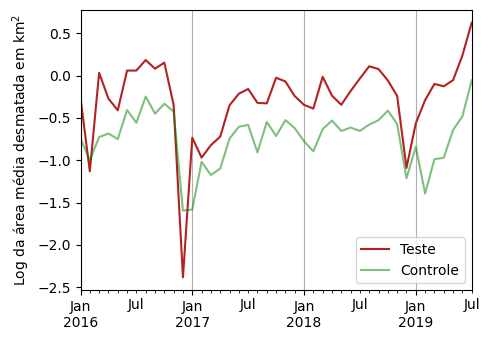

In [41]:
pl.figure(figsize=(5,3.5))
np.log10(glo_series / len(mun_teste)).plot(label='Teste', color='firebrick')
np.log10(ctrl_series  / len(mun_controle)).plot(label='Controle', color='g', alpha=0.5)
# Format:
pl.ylabel('Log da área média desmatada em $\mathrm{km^2}$')
pl.xlabel('')
pl.grid(axis='x')
pl.legend()
pl.tight_layout()
#pl.savefig('../resultados/plots/comparacao_evolucao_log_area_teste_controle.png')
pl.show()

In [98]:
# Correlação entre as duas séries:
np.corrcoef(np.log10(glo_series), np.log10(ctrl_series))[0,1]

0.7824981677375709

In [47]:
# Fração da variância explicada pelo grupo controle:
from sklearn.metrics import r2_score
r2_score(np.log10(glo_series), np.log10(ctrl_series * log_shift))

0.5805549265769614

Resíduos não são correlacionados: seleção com base nos resíduos de um dado mês é aleatória para os outros meses

In [96]:
# Calcula o resíduo dos logs do desmatamento:
pre_avg_series = pre_monthly_area_glo_df.groupby('month')['areaMunKm'].mean()
log_residuos = np.log10(glo_series / pre_avg_series)

# Calcula a correlação p/ vários lags:
lag_df = pd.DataFrame()
for i in range(0, 13):
    lag_df[i] = log_residuos.shift(i)
#lag_df = lag_df.dropna()
lag_corr = lag_df.corr()

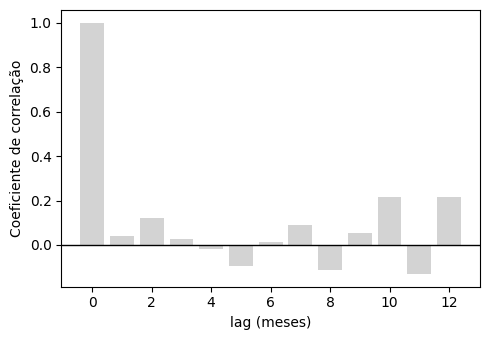

In [108]:
pl.figure(figsize=(5,3.5))
pl.bar(lag_corr[0].index, lag_corr[0].values, color='lightgray')
pl.axhline(0, linewidth=1, color='k')
pl.ylabel('Coeficiente de correlação')
pl.xlabel('lag (meses)')
pl.tight_layout()
#pl.savefig('../resultados/plots/correlacao_lag_residuos_grupo_com_GLOs.png')
pl.show()

#### Teste de shift na série temporal

Vamos comparar a sazonalidade dos municípios com GLOs com a sazonalidade dos demais, para ver se estão na mesma fase.

**Conclusão:** Na comparação de shifts de no mínimo um mês, o melhor resultado é sem shift.

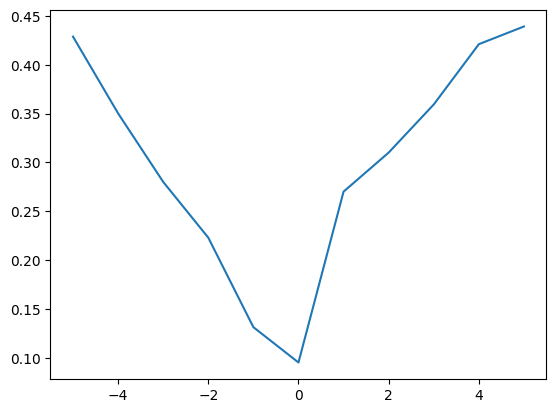

In [48]:
# Minimização da amplitude dos resíduos leva a minimização da diferença de fase: 
mse = []
shift_list = np.array(range(-5, 6))
for ctrl_shift in shift_list:
    ctrl_series = pre_monthly_area_glo_df.query('glo == 0').groupby('month')['areaMunKm'].sum().shift(ctrl_shift)
    glo_series  = pre_monthly_area_glo_df.query('glo == 1').groupby('month')['areaMunKm'].sum()
    log_shift   = glo_series.mean() / ctrl_series.mean()
    mse.append((np.log10(glo_series / (ctrl_series * log_shift))**2).mean())

pl.plot(shift_list, mse)
pl.show()

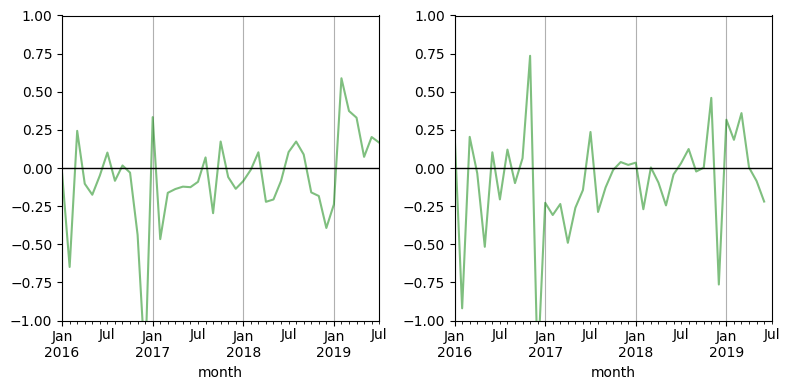

In [49]:
# Comparação dos dois melhores casos de shift:

pl.figure(figsize=(8,4))

pl.subplot(1,2,1)
ctrl_shift = 0
pre_monthly_area_glo_df = monthly_area_glo_df.loc[monthly_area_glo_df['month'] < no_glo_date]
glo_series  = pre_monthly_area_glo_df.query('glo == 1').groupby('month')['areaMunKm'].sum()
ctrl_series = pre_monthly_area_glo_df.query('glo == 0').groupby('month')['areaMunKm'].sum().shift(ctrl_shift)
log_shift   = glo_series.mean() / ctrl_series.mean()
np.log10(glo_series / (ctrl_series * log_shift)).plot(label='Resíduos', color='g', alpha=0.5)
pl.grid(axis='x')
pl.axhline(0, color='k', linewidth=1)
pl.ylim([-1, 1])

pl.subplot(1,2,2)
ctrl_shift = -1
pre_monthly_area_glo_df = monthly_area_glo_df.loc[monthly_area_glo_df['month'] < no_glo_date]
glo_series  = pre_monthly_area_glo_df.query('glo == 1').groupby('month')['areaMunKm'].sum()
ctrl_series = pre_monthly_area_glo_df.query('glo == 0').groupby('month')['areaMunKm'].sum().shift(ctrl_shift)
log_shift   = glo_series.mean() / ctrl_series.mean()
np.log10(glo_series / (ctrl_series * log_shift)).plot(label='Resíduos', color='g', alpha=0.5)
pl.grid(axis='x')
pl.axhline(0, color='k', linewidth=1)
pl.ylim([-1, 1])

pl.tight_layout()
pl.show()

### Comparação das séries temporais

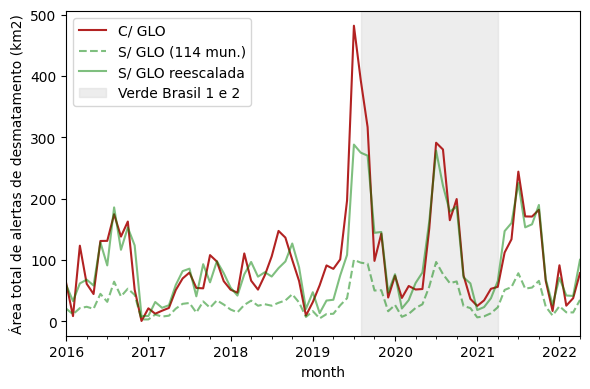

In [194]:
ctrl_series = monthly_area_glo_df.query('glo == 0').groupby('month')['areaMunKm'].sum()
glo_series  = monthly_area_glo_df.query('glo == 1').groupby('month')['areaMunKm'].sum()
log_shift   = glo_series.mean() / ctrl_series.mean()
#log_shift   = glo_series[:'2019-01-01'].mean() / ctrl_series[:'2019-01-01'].mean()

pl.figure(figsize=(6,4))
glo_series.plot(label='C/ GLO', color='firebrick')
(ctrl_series / len(mun_controle) * len(mun_teste)).plot(label='S/ GLO (114 mun.)', color='g', alpha=0.5, linestyle='--') 
(ctrl_series * log_shift).plot(label='S/ GLO reescalada', color='g', alpha=0.5)
pl.ylabel('Área total de alertas de desmatamento (km2)')
#pl.yscale('log')
#pl.axvline(monthly_area_glo_df['first_glo_month'].min(), color='k', linewidth=1, linestyle='--')
#pl.axvline(monthly_area_glo_df['last_glo_month'].max(), color='k', linewidth=1, linestyle='--')
pl.axvspan(monthly_area_glo_df['first_glo_month'].min(), monthly_area_glo_df['last_glo_month'].max(), alpha=0.4, color='lightgray', label='Verde Brasil 1 e 2')

pl.legend()
pl.tight_layout()
#pl.savefig('../resultados/plots/area_alerta_GLOs_Controle_2016-2022.png')
pl.show()

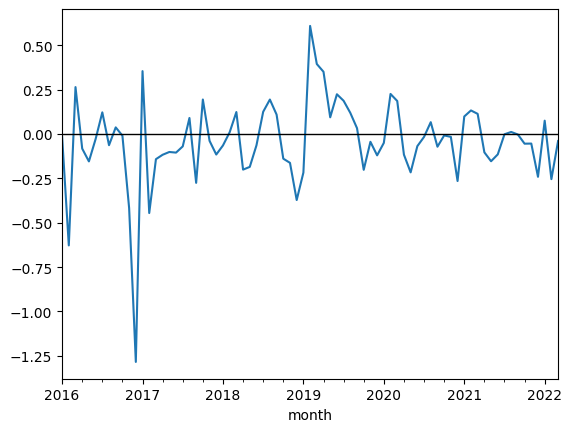

In [56]:
np.log10(glo_series / (ctrl_series * log_shift)).plot()
pl.axhline(0, linewidth=1, color='k')
pl.show()

### Regressão à média

In [26]:
# Cálculo dos resíduos para todos os municípios:
monthly_residuals_df = compute_residuals_4all(monthly_area_glo_df)

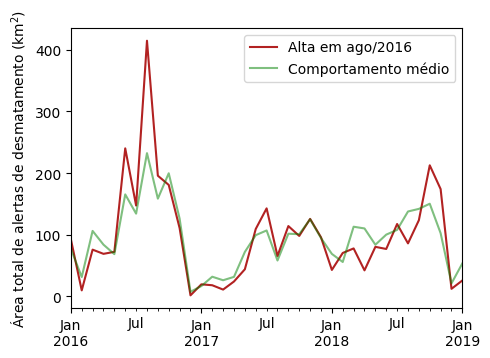

In [40]:
# Seleção de municípios com excesso de desmatamento em uma determinada data:
extreme_set = list_extreme_alert_places(monthly_residuals_df, '2016-08-01', len(mun_teste))

# Gráfico do desmatamento ao longo do tempo:
ctrl_series    = monthly_area_glo_df.groupby('month')['areaMunKm'].sum()
extreme_series = monthly_area_glo_df.loc[monthly_area_glo_df['tag'].isin(extreme_set)].groupby('month')['areaMunKm'].sum()
log_shift   = extreme_series.mean() / ctrl_series.mean()

pl.figure(figsize=(5,3.5))
extreme_series[:'2019-01-01'].plot(label='Alta em ago/2016', color='firebrick')
#(ctrl_series[:'2019-01-01'] / len(mun_controle) * len(mun_teste)).plot(label='S/ GLO (114 mun.)', color='g', alpha=0.5, linestyle='--') 
(ctrl_series[:'2019-01-01'] * log_shift).plot(label='Comportamento médio', color='g', alpha=0.5)
pl.ylabel('Área total de alertas de desmatamento ($\mathrm{km^2}$)')
#pl.yscale('log')
#pl.axvline(monthly_area_glo_df['first_glo_month'].min(), color='k', linewidth=1, linestyle='--')
#pl.axvline(monthly_area_glo_df['last_glo_month'].max(), color='k', linewidth=1, linestyle='--')
#pl.axvspan(monthly_area_glo_df['first_glo_month'].min(), monthly_area_glo_df['last_glo_month'].max(), alpha=0.4, color='lightgray', label='Verde Brasil 1 e 2')

pl.xlabel('')
pl.legend()
pl.tight_layout()
#pl.savefig('../resultados/plots/exemplo_regressao_a_media_desmatamento_deter.png')
pl.show()

## Mapas dos locais das GLOs

In [78]:
# Cód. IBGE dos municípios com GLOs:
cod_ibge_glo = mun_glos_df.loc[mun_glos_df['tag'].isin(mun_teste), 'CodIbge']
# Municípios da Samauma:
cod_samauma = mun_glos_df.loc[mun_glos_df['samauma'] == 'sim', 'CodIbge'].unique()

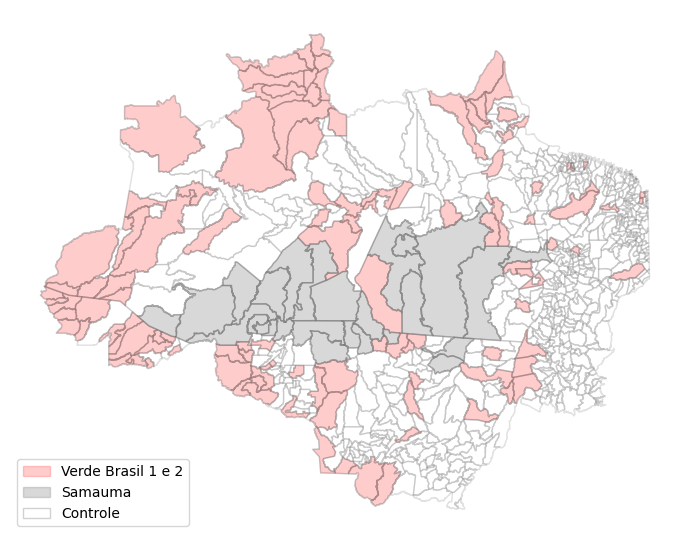

In [93]:
fig = pl.figure(figsize=(7,7))
ax = pl.subplot(1,1,1)
mun_gdf.plot(color='none', edgecolor='dimgray', ax=ax, alpha=0.2)
mun_gdf.loc[mun_gdf['cod_ibge'].isin(cod_ibge_glo)].plot(color='r', edgecolor='dimgray', ax=ax, alpha=0.2)
mun_gdf.loc[mun_gdf['cod_ibge'].isin(cod_samauma)].plot(color='gray', edgecolor='dimgray', ax=ax, alpha=0.3)

legend_elements = [Patch(color='r', alpha=0.2, label='Verde Brasil 1 e 2'), 
                   Patch(color='gray', alpha=0.3, label='Samauma'),
                   Patch(facecolor='white', edgecolor='dimgray', alpha=0.3, label='Controle')]
pl.legend(handles=legend_elements, loc='lower left')
pl.axis('off')
pl.tight_layout()
#pl.savefig('../resultados/plots/mapa_municipios_verde_brasil_1e2.png')
pl.show()

In [258]:
# Criação de base com centroide dos municípios com GLOs:
mun_com_glo_gdf = mun_gdf.loc[mun_gdf['cod_ibge'].isin(cod_ibge_glo)].copy()
mun_com_glo_gdf['geometry'] = mun_com_glo_gdf.to_crs('epsg:5641')['geometry'].centroid
xd.add_column_suffix(mun_com_glo_gdf, '_test', inplace=True)
mun_com_glo_gdf.rename({'geometry_test': 'geometry'}, axis=1, inplace=True)

# Criação de base com centroide dos municípios sem GLOs:
mun_sem_glo_gdf = mun_gdf.loc[~mun_gdf['cod_ibge'].isin(cod_ibge_glo)].copy()
mun_sem_glo_gdf['geometry'] = mun_sem_glo_gdf.to_crs('epsg:5641')['geometry'].centroid
xd.add_column_suffix(mun_sem_glo_gdf, '_ctrl', inplace=True)
mun_sem_glo_gdf.rename({'geometry_ctrl': 'geometry'}, axis=1, inplace=True)

# Identificação das GLOs mais próximas dos municípios sem:
xg.find_nearest(mun_sem_glo_gdf, mun_com_glo_gdf)

## Teste de modelo para o desmatamento

In [116]:
def huber_fn(y_true, y_pred, threshold):
    
    error = y_true - y_pred
    
    is_small_error = np.abs(error) < threshold
    
    squared_loss = error ** 2 / 2
    linear_loss  = threshold * np.abs(error) - threshold ** 2 / 2
    huber_loss   = np.where(is_small_error, squared_loss, linear_loss)
    
    return huber_loss

### Município a município

**Conclusão:** Verificamos que o modelo escalar, no qual a amplitude do modelo se ajusta ao município, descreve melhor os dados que o modelo típico de Diferenças em Diferenças.

In [27]:
# Seleciona dados anteriores às GLOs:
mensal_pre_glo_df = complete_area_df.loc[complete_area_df['month'] < '2019-07-01']
# Calcula comportamento médio dos avisos:
mensal_medio = mensal_pre_glo_df.groupby('month')['areaMunKm'].mean().sort_index()

In [56]:
# Colhe erro quadrático médio do ajuste aos municípios:
linear_r = []
scalar_r = []
scalar_x = []
desmatavel = []
area_total = []
scalar_resid = []
frac_scalar_resid = []
tags = mensal_pre_glo_df['tag'].unique()
for m in tags:
    mensal_mun = mensal_pre_glo_df.loc[mensal_pre_glo_df['tag'] == m].set_index('month')['areaMunKm'].sort_index()
    min_linear_model = minimize_scalar(linear_chi2, args=(mensal_medio, mensal_mun))
    min_scalar_model = minimize_scalar(scalar_chi2, args=(mensal_medio, mensal_mun))
    linear_r.append(min_linear_model.fun)
    scalar_r.append(min_scalar_model.fun)
    scalar_x.append(min_scalar_model.x)
    scalar_resid.append(mensal_mun - scalar_model(min_scalar_model.x, mensal_medio))
    frac_scalar_resid.append(mensal_mun / scalar_model(min_scalar_model.x, mensal_medio) - 1)
    mun_data = mun_glos_area_df.loc[mun_glos_area_df['tag'] == m].iloc[0]
    desmatavel.append(mun_data['Desmatavel'])
    area_total.append(mun_data['AreaKm2'])

#### Comparação do modelo escalar com o linear (tradicional do DiD)

In [49]:
np.mean(linear_r)

226.94721918369945

In [50]:
np.mean(scalar_r)

126.17604599295147

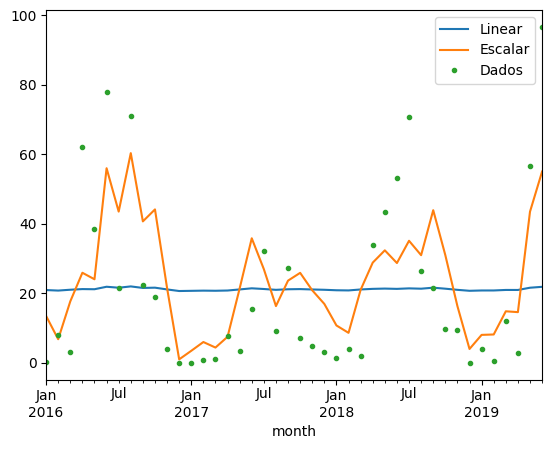

In [51]:
mensal_mun = mensal_pre_glo_df.loc[mensal_pre_glo_df['tag'] == mensal_pre_glo_df['tag'].unique()[18]].set_index('month')['areaMunKm'].sort_index()
min_linear_model = minimize_scalar(linear_chi2, args=(mensal_medio, mensal_mun))
min_scalar_model = minimize_scalar(scalar_chi2, args=(mensal_medio, mensal_mun))

linear_model(min_linear_model.x, mensal_medio).plot(label='Linear')
scalar_model(min_scalar_model.x, mensal_medio).plot(label='Escalar')
mensal_mun.plot(marker='.', label='Dados', linestyle='')
pl.legend()
pl.show()

#### Estudo dos resíduos

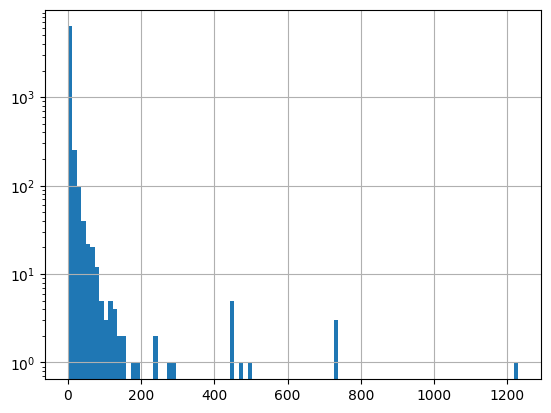

In [83]:
all_resid = pd.concat(frac_scalar_resid)
#all_resid = pd.concat(scalar_resid)
all_resid.loc[all_resid > -1].hist(bins=100)
pl.yscale('log')
pl.show()

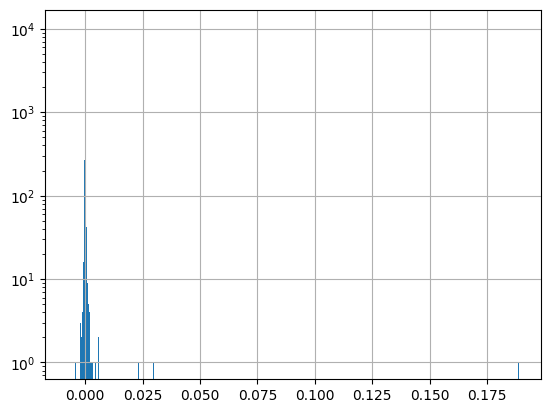

In [95]:
all_resid = pd.concat([r / d for r, d in zip(scalar_resid, desmatavel)])
all_resid.loc[all_resid != 0].hist(bins=5000)
pl.yscale('log')
#pl.xlim([-0.001, 0.001])
pl.show()

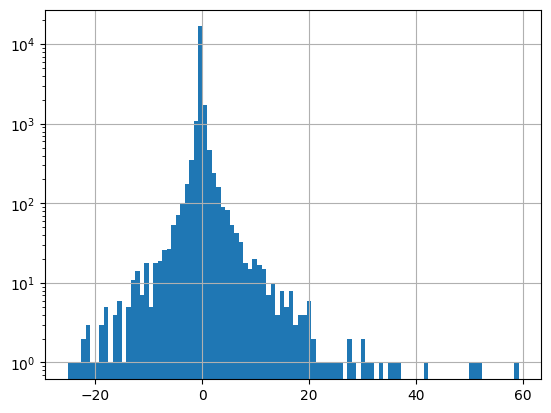

In [82]:
all_resid = pd.concat(scalar_resid)
all_resid.loc[all_resid != 0].hist(bins=100)
pl.yscale('log')
pl.show()

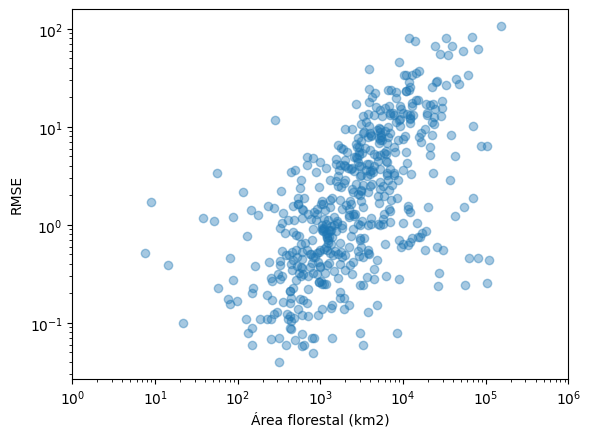

In [70]:
pl.scatter(desmatavel, np.sqrt(scalar_r), alpha=0.4)
pl.xlabel('Área florestal (km2)')
pl.ylabel('RMSE')
pl.yscale('log')
pl.xscale('log')
pl.xlim([1, 1e6])
pl.show()

In [22]:
np.corrcoef(desmatavel, np.sqrt(scalar_r))

array([[1.       , 0.5209751],
       [0.5209751, 1.       ]])

In [23]:
np.corrcoef(area_total, np.sqrt(scalar_r))

array([[1.        , 0.50586715],
       [0.50586715, 1.        ]])

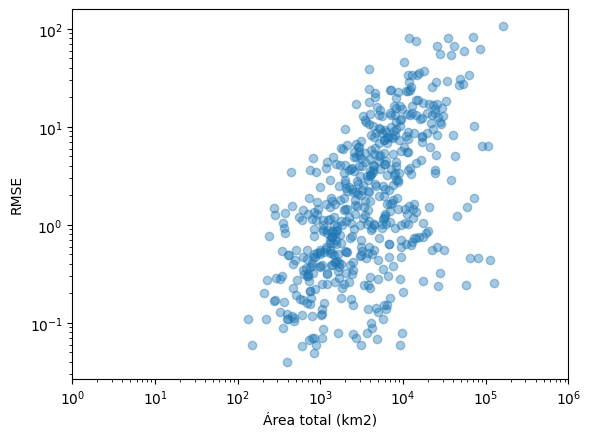

In [71]:
pl.scatter(area_total, np.sqrt(scalar_r), alpha=0.4)
pl.xlabel('Área total (km2)')
pl.ylabel('RMSE')
pl.yscale('log')
pl.xscale('log')
pl.xlim([1, 1e6])
pl.show()

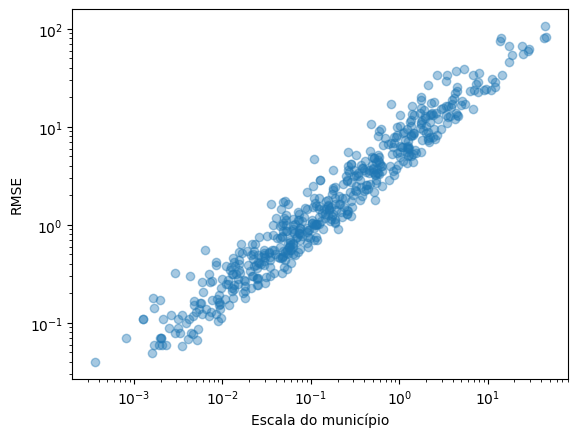

In [72]:
pl.scatter(scalar_x, np.sqrt(scalar_r), alpha=0.4)
pl.xlabel('Escala do município')
pl.ylabel('RMSE')
pl.yscale('log')
pl.xscale('log')
pl.show()

<ipython-input-58-b0f232269cbe>:2: RuntimeWarning: invalid value encountered in true_divide
  resid_series = pd.Series((np.array(scalar_resid).T / np.array(scalar_x)).flatten())


<AxesSubplot:>

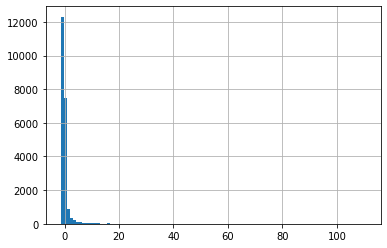

In [58]:
# Distribuição dos resíduos re-escalados não é Gaussiana.
resid_series = pd.Series((np.array(scalar_resid).T / np.array(scalar_x)).flatten())
resid_series.loc[~resid_series.isnull()].hist(bins=100)

### Conjuntos de municípios

In [100]:
# Seleciona dados anteriores às GLOs:
mensal_pre_glo_df = complete_area_df.loc[complete_area_df['month'] < '2019-07-01']
# Municípios existentes:
mun_series = mensal_pre_glo_df['tag'].drop_duplicates()

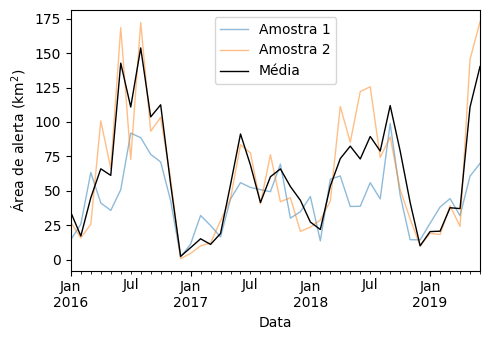

In [125]:
n_samples  = 2
n_join_mun = 114
avg_random_region = mensal_pre_glo_df.groupby('month')['areaMunKm'].mean() * n_join_mun
random_region_df = pd.DataFrame()
for i in range(n_samples):
    random_region_df[i] = agg_random_area_alert(mensal_pre_glo_df, n_join_mun)

pl.figure(figsize=(5,3.5))
for i in range(n_samples):
    (random_region_df[i]).plot(linewidth=1, alpha=0.5, label='Amostra {}'.format(i + 1))
avg_random_region.plot(linewidth=1, color='k', label='Média')
#pl.yscale('log')
pl.ylabel('Área de alerta ($\mathrm{km^2}$)')
pl.xlabel('Data')
pl.tight_layout()
pl.legend()
#pl.savefig('../resultados/plots/area_alerta_deter_por_mes_soma_141_municipios_02.png')
pl.show()

In [115]:
# Calcula a área de alerta média de uma amostra de `n_join_mun` municípios:
n_join_mun = 114
avg_random_region = mensal_pre_glo_df.groupby('month')['areaMunKm'].mean() * n_join_mun

# Obtém os resíduos do ajuste do modelo a conjuntos aleatórios de municípios:
res_list = []
fit_list = []
for _ in range(100):
    # Agrega alertas para uma seleção aleatória de municípios:
    y = agg_random_area_alert(mensal_pre_glo_df, n_join_mun)

    # Ajusta um modelo e obtém os resíduos:
    min_scalar_model = minimize_scalar(scalar_chi2, args=(avg_random_region, y))
    y_model = scalar_model(min_scalar_model.x, avg_random_region)
    res = y - y_model

    # Guarda resultados:
    res_list.append(res)
    fit_list.append(y_model)

In [116]:
# Concatena os resultados em um DataFrame:
res_series = pd.concat(res_list)
fit_series = pd.concat(fit_list)
res_df = pd.DataFrame({'residuals': res_series, 'model': fit_series}).reset_index(drop=True)
n_bins = 18
res_df['model_bin'] = pd.cut(res_df['model'], np.linspace(res_df['model'].min(), res_df['model'].max(), n_bins)).apply(lambda x: x.mid)
res_df['bin_width'] = pd.cut(res_df['model'], np.linspace(res_df['model'].min(), res_df['model'].max(), n_bins)).apply(lambda x: x.length)

In [117]:
bin_dev   = res_df.groupby('model_bin')['residuals'].std()
bin_width = res_df.groupby('model_bin')['bin_width'].mean()

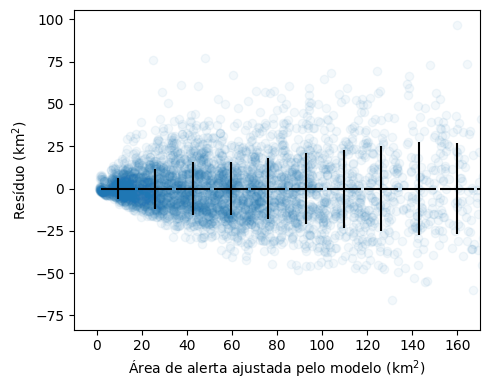

In [118]:
pl.figure(figsize=(5,4))
pl.scatter(fit_series, res_series, alpha=0.05)

pl.errorbar(bin_dev.index, np.zeros_like(bin_dev), yerr=bin_dev, xerr=bin_width*0.45, linestyle='none', color='k')

pl.ylabel('Resíduo ($\mathrm{km^2}$)')
pl.xlabel('Área de alerta ajustada pelo modelo ($\mathrm{km^2}$)')
pl.tight_layout()
pl.xlim([-10, 170])
#pl.savefig('../resultados/plots/residuos_modelo_multiplicativo_desmatamento_deter.png')
pl.show()

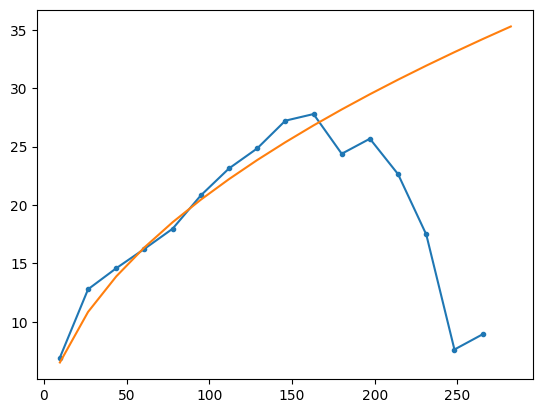

In [114]:
pl.plot(bin_dev.index.astype(float), bin_dev, marker='.')
pl.plot(bin_dev.index.astype(float), 2.1*np.sqrt(bin_dev.index))
pl.show()

## Relação entre área dos municípios e área dos alertas

In [104]:
test = mensal_cleaned_df.loc[mensal_cleaned_df['month_date'] == '2019-07-01'].join(mun_glos_df.set_index('tag')['AreaKm2'], on='tag')

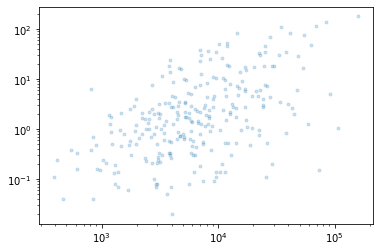

In [110]:
pl.scatter(test['AreaKm2'], test['areaMunKm'], marker='.', alpha=0.2)
pl.yscale('log')
pl.xscale('log')
pl.show()

<AxesSubplot:>

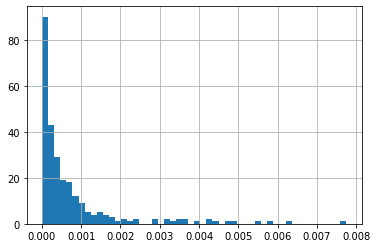

In [116]:
(test['areaMunKm'] / test['AreaKm2']).hist(bins=50)

In [100]:
mun_glos_df

,Nr,Lat,Long,Latgms,Longms,Municipio,CodIbge,Estado,AreaKm2,verde_brasil_1,verde_brasil_1_inicio,verde_brasil_1_final,outro_nome,verde_brasil_2,verde_brasil_2_inicio,verde_brasil_2_final,samauma,samauma_inicio,samauma_final,tag
0,326,-1.73866,-48.85524,S 1 44 19.18,O 48 51 18.86,Abaetetuba,1500107,PA,1617,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaT,NaT,ABAETETUBA - PA
1,328,-4.96265,-48.39406,S 4 57 45.54,O 48 23 38.62,Abel Figueiredo,1500131,PA,616,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaT,NaT,ABEL FIGUEIREDO - PA
2,484,-9.46606,-49.33901,S 9 27 57.82,O 49 20 20.44,Abreulândia,1700251,TO,1900,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaT,NaT,ABREULANDIA - TO
3,110,-4.70208,-47.22036,S 4 42 7.49,O 47 13 13.30,Açailândia,2100055,MA,5846,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaT,NaT,ACAILANDIA - MA
4,128,-2.03379,-48.31904,S 2 2 1.64,O 48 19 8.54,Acará,1500206,PA,4361,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaT,NaT,ACARA - PA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,369,-6.88444,-47.99094,S 6 53 3.98,O 47 59 27.38,Wanderlândia,1722081,TO,1382,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaT,NaT,WANDERLANDIA - TO
756,344,-6.59866,-48.48198,S 6 35 55.18,O 48 28 55.13,Xambioá,1722107,TO,1191,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaT,NaT,XAMBIOA - TO
757,66,-10.61178,-68.46285,S 10 36 42.41,O 68 27 46.26,Xapuri,1200708,AC,5511,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,NaT,NaT,XAPURI - AC
758,311,-6.84864,-49.25551,S 6 50 55.10,O 49 15 19.84,Xinguara,1508407,PA,3793,sim,2019-08-24,2019-09-24,NaN,NaN,NaT,NaT,NaN,NaT,NaT,XINGUARA - PA


## Explorando dados das GLOs

### Consistência entre registro da GLO e datas

In [73]:
# Certifica que quando existe a operação, também existe as datas de início e de término:
assert xe.checkMissing(mun_glos_df.loc[~mun_glos_df['verde_brasil_1'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['verde_brasil_1_inicio']['N'] == 0
assert xe.checkMissing(mun_glos_df.loc[~mun_glos_df['verde_brasil_1'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['verde_brasil_1_final']['N'] == 0
assert xe.checkMissing(mun_glos_df.loc[~mun_glos_df['verde_brasil_2'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['verde_brasil_2_inicio']['N'] == 0
assert xe.checkMissing(mun_glos_df.loc[~mun_glos_df['verde_brasil_2'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['verde_brasil_2_final']['N'] == 0
assert xe.checkMissing(mun_glos_df.loc[~mun_glos_df['samauma'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['samauma_inicio']['N'] == 0
assert xe.checkMissing(mun_glos_df.loc[~mun_glos_df['samauma'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['samauma_final']['N'] == 0

# Certifica que quando não existe a operação, também não existem as datas de início e de término:
assert xe.checkMissing(mun_glos_df.loc[mun_glos_df['verde_brasil_1'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['verde_brasil_1_inicio']['%'] == 100
assert xe.checkMissing(mun_glos_df.loc[mun_glos_df['verde_brasil_1'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['verde_brasil_1_final']['%'] == 100
assert xe.checkMissing(mun_glos_df.loc[mun_glos_df['verde_brasil_2'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['verde_brasil_2_inicio']['%'] == 100
assert xe.checkMissing(mun_glos_df.loc[mun_glos_df['verde_brasil_2'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['verde_brasil_2_final']['%'] == 100
assert xe.checkMissing(mun_glos_df.loc[mun_glos_df['samauma'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['samauma_inicio']['%'] == 100
assert xe.checkMissing(mun_glos_df.loc[mun_glos_df['samauma'].isnull()], return_df=True, only_missing=False).set_index('coluna').loc['samauma_final']['%'] == 100

### Datas das GLOs

#### Verde Brasil 1

In [45]:
mun_glos_df['verde_brasil_1_inicio'].min()

Timestamp('2019-08-24 00:00:00')

In [44]:
mun_glos_df['verde_brasil_1_final'].max()

Timestamp('2019-10-24 00:00:00')

#### Verde Brasil 2

In [47]:
mun_glos_df['verde_brasil_2_inicio'].min()

Timestamp('2020-04-14 00:00:00')

In [46]:
mun_glos_df['verde_brasil_2_final'].max()

Timestamp('2021-12-09 00:00:00')

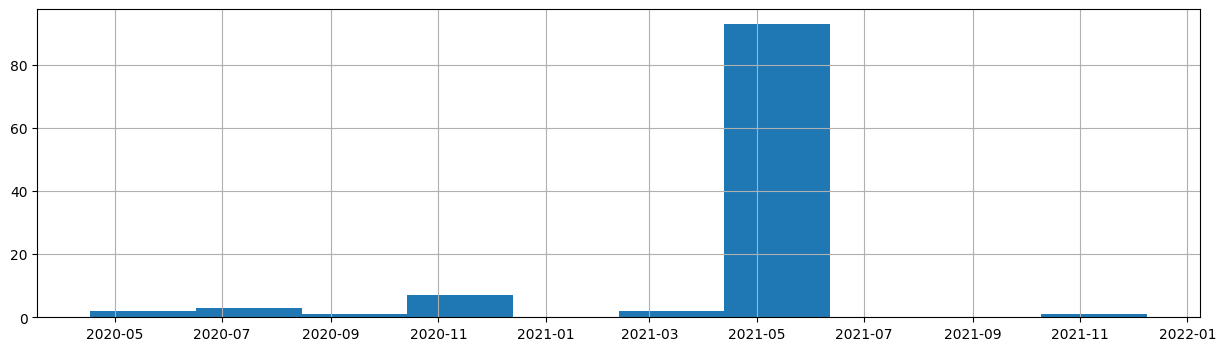

In [49]:
pl.figure(figsize=(15,4))
mun_glos_df['verde_brasil_2_final'].hist()
pl.show()

In [54]:
len(mun_glos_df['verde_brasil_2'].dropna())

109

In [52]:
# A maioria dos municípios tiveram a Verde Brasil encerrando em abril de 2021:
mun_glos_df['verde_brasil_2_final'].dropna().sort_values().tail(10)

293   2021-04-30
286   2021-04-30
285   2021-04-30
245   2021-04-30
244   2021-04-30
242   2021-04-30
222   2021-04-30
220   2021-04-30
375   2021-04-30
459   2021-12-09
Name: verde_brasil_2_final, dtype: datetime64[ns]

#### Samauma

In [55]:
mun_glos_df['samauma_inicio'].min()

Timestamp('2021-06-28 00:00:00')

In [56]:
mun_glos_df['samauma_final'].max()

Timestamp('2021-08-31 00:00:00')

In [57]:
len(mun_glos_df['samauma'].dropna())

27

### Sequência das GLOs

Existe um único overlap de GLOs: no município de Novo Progresso - PA entre as GLOs Verde Brasil 2 e Samaúma.

In [74]:
(mun_glos_df['verde_brasil_2_inicio'] - mun_glos_df['verde_brasil_1_final']).min()

Timedelta('200 days 00:00:00')

In [75]:
(mun_glos_df['samauma_inicio'] - mun_glos_df['verde_brasil_2_final']).min()

Timedelta('-151 days +00:00:00')

<AxesSubplot:>

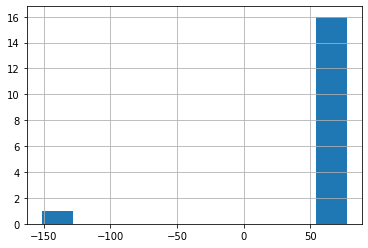

In [76]:
(mun_glos_df['samauma_inicio'] - mun_glos_df['verde_brasil_2_final']).dt.days.hist()

In [77]:
mun_glos_df.loc[(mun_glos_df['samauma_inicio'] - mun_glos_df['verde_brasil_2_final']).dt.days < 0]

,Nr,Lat,Long,Latgms,Longms,Municipio,CodIbge,Estado,AreaKm2,verde_brasil_1,verde_brasil_1_inicio,verde_brasil_1_final,outro_nome,verde_brasil_2,verde_brasil_2_inicio,verde_brasil_2_final,samauma,samauma_inicio,samauma_final,tag
459,5,-7.90803,-55.59552,S 7 54 28.91,O 55 35 43.87,Novo Progresso,1505031,PA,38183,sim,2019-08-24,2019-09-24,Cachimbo,sim,2020-06-08,2021-12-09,sim,2021-07-11,2021-08-31,NOVO PROGRESSO - PA


### Repetição de GLOs nos municípios

* 63% dos municípios da Verde Brasil 1 receberam a Verde Brasil 2 depois.
* 39% dos municípios da Verde Brasil 2 já tinham sido parte da Verde Brasil 1.

* 63% dos municípios da Samaúma já tinham recebido a Verde Brasil 2.
* 15% dos municípios da Verde Brasil 2 receberam a Samaúma depois.

In [78]:
len(sel_mun_in_glo(mun_glos_df, ['samauma', 'verde_brasil_2'])) / len(sel_mun_in_glo(mun_glos_df, ['samauma']))

0.6296296296296297

In [79]:
len(sel_mun_in_glo(mun_glos_df, ['samauma', 'verde_brasil_2'])) / len(sel_mun_in_glo(mun_glos_df, ['verde_brasil_2']))

0.1559633027522936

In [80]:
len(sel_mun_in_glo(mun_glos_df, ['verde_brasil_1', 'verde_brasil_2'])) / len(sel_mun_in_glo(mun_glos_df, ['verde_brasil_1']))

0.6268656716417911

In [81]:
len(sel_mun_in_glo(mun_glos_df, ['verde_brasil_1', 'verde_brasil_2'])) / len(sel_mun_in_glo(mun_glos_df, ['verde_brasil_2']))

0.3853211009174312

In [58]:
n_mun_join

114

### Duração das operações

In [82]:
verde_1_days = (mun_glos_df['verde_brasil_1_final'] - mun_glos_df['verde_brasil_1_inicio']).dt.days
verde_1_days.value_counts()

61.0    42
31.0    14
50.0    11
dtype: int64

In [83]:
verde_2_days = (mun_glos_df['verde_brasil_2_final'] - mun_glos_df['verde_brasil_2_inicio']).dt.days
verde_2_days.value_counts()

354.0    92
3.0       4
72.0      2
1.0       2
549.0     1
341.0     1
34.0      1
47.0      1
37.0      1
79.0      1
4.0       1
23.0      1
21.0      1
dtype: int64

<AxesSubplot:>

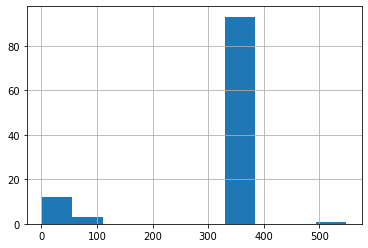

In [84]:
verde_2_days.hist()

In [85]:
samauma_days = (mun_glos_df['samauma_final'] - mun_glos_df['samauma_inicio']).dt.days
samauma_days.value_counts()

64.0    13
45.0     8
51.0     2
41.0     1
42.0     1
55.0     1
57.0     1
dtype: int64

<AxesSubplot:>

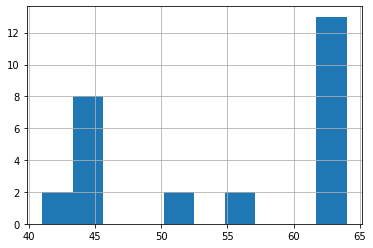

In [86]:
samauma_days.hist()

In [87]:
mun_glos_df.loc[(mun_glos_df['verde_brasil_2_final'] - mun_glos_df['verde_brasil_2_inicio']).dt.days < 5]

,Nr,Lat,Long,Latgms,Longms,Municipio,CodIbge,Estado,AreaKm2,verde_brasil_1,verde_brasil_1_inicio,verde_brasil_1_final,outro_nome,verde_brasil_2,verde_brasil_2_inicio,verde_brasil_2_final,samauma,samauma_inicio,samauma_final,tag
147,427,-2.28082,-49.51546,S 2 16 50.95,O 49 30 55.66,Cametá,1502103,PA,3090,NaN,NaT,NaT,NaN,sim,2020-05-18,2020-05-22,NaN,NaT,NaT,CAMETA - PA
163,411,-1.18797,-47.12751,S 1 11 16.69,O 47 7 39.04,Capanema,1502202,PA,619,NaN,NaT,NaT,NaN,sim,2020-06-26,2020-06-29,NaN,NaT,NaT,CAPANEMA - PA
291,232,-1.12099,-51.49156,S 1 7 15.56,O 51 29 29.62,Gurupá,1503101,PA,8550,NaN,NaT,NaT,Gurupi,sim,2020-06-26,2020-06-29,NaN,NaT,NaT,GURUPA - PA
325,25,-7.47718,-57.60432,S 7 28 37.85,O 57 36 15.55,Jacareacanga,1503754,PA,53397,sim,2019-08-24,2019-09-24,Cachimbo,sim,2020-08-07,2020-08-08,NaN,NaT,NaT,JACAREACANGA - PA
487,229,-6.19825,-50.43010,S 6 11 53.70,O 50 25 48.36,Parauapebas,1505536,PA,6968,NaN,NaT,NaT,NaN,sim,2021-03-25,2021-03-26,NaN,NaT,NaT,PARAUAPEBAS - PA
681,12,-3.55820,-51.73873,S 3 33 29.52,O 51 44 19.43,Senador José Porfírio,1507805,PA,14389,NaN,NaT,NaT,NaN,sim,2020-04-14,2020-04-17,NaN,NaT,NaT,SENADOR JOSE PORFIRIO - PA
759,348,-3.25303,-45.97435,S 3 15 10.91,O 45 58 27.66,Zé Doca,2114007,MA,2438,NaN,NaT,NaT,NaN,sim,2020-10-14,2020-10-17,NaN,NaT,NaT,ZE DOCA - MA


In [88]:
mun_glos_df.loc[mun_glos_df['Municipio'] == 'Vista Alegre']

,Nr,Lat,Long,Latgms,Longms,Municipio,CodIbge,Estado,AreaKm2,verde_brasil_1,verde_brasil_1_inicio,verde_brasil_1_final,outro_nome,verde_brasil_2,verde_brasil_2_inicio,verde_brasil_2_final,samauma,samauma_inicio,samauma_final,tag


## Explorando dados do Deter

In [89]:
# Agregado mensal e estadual:
deter_mensal_filename = '../dados/brutos/desmatamento/terrabrasilis_deter/deter_desmatamento_mensal_2022-02.csv'
deter_mensal_df = pd.read_csv(deter_mensal_filename)
max_date = re.search(r'\d{4}-\d{2}', deter_mensal_filename).group(0) + '-01'
deter_mensal_df['data'] = pd.to_datetime(deter_mensal_df['year'].astype(str) + deter_mensal_df['month'].astype(str) + '01', format='%Y%m%d')

# Filter data to include only complete months:
deter_mensal_df = deter_mensal_df.loc[deter_mensal_df['data'] <= max_date]

### Características gerais do Deter diário

Existem linhas sem municípios associados:

In [90]:
xe.checkMissing(deter_diario_df)

Colunas com valores faltantes:
      coluna       N      %
3         uc  181686  95.02
4         uf      11   0.01
5  municipio      11   0.01
9        tag      11   0.01


Esses casos são quase todos sem desmatamento algum, e todos são sem desmatamento no município:

In [91]:
deter_diario_df.loc[deter_diario_df['uf'].isnull()]

,viewDate,areaMunKm,areaUcKm,uc,uf,municipio,year,month,month_date,tag
7955,2020-03-03,0.0,0.00,NaN,NaN,NaN,2020,3,2020-03-01,NaN
8122,2020-03-03,0.0,0.05,RESERVA EXTRATIVISTA CHICO MENDES,NaN,NaN,2020,3,2020-03-01,NaN
8412,2020-04-30,0.0,0.00,NaN,NaN,NaN,2020,4,2020-04-01,NaN
11314,2020-03-03,0.0,0.00,NaN,NaN,NaN,2020,3,2020-03-01,NaN
33403,2018-08-03,0.0,0.00,NaN,NaN,NaN,2018,8,2018-08-01,NaN
52961,2020-07-17,0.0,0.00,NaN,NaN,NaN,2020,7,2020-07-01,NaN
52966,2020-07-17,0.0,0.00,NaN,NaN,NaN,2020,7,2020-07-01,NaN
77470,2020-06-22,0.0,0.00,NaN,NaN,NaN,2020,6,2020-06-01,NaN
81617,2020-06-18,0.0,0.00,NaN,NaN,NaN,2020,6,2020-06-01,NaN
85436,2020-06-15,0.0,0.00,NaN,NaN,NaN,2020,6,2020-06-01,NaN


O intervalo de tempo coberto é realmente o especificado pelo nome do arquivo:

In [92]:
deter_diario_df['viewDate'].min()

Timestamp('2016-01-11 00:00:00')

In [93]:
deter_diario_df['viewDate'].max()

Timestamp('2022-03-25 00:00:00')

In [94]:
municipios = deter_diario_df['municipio'].unique()

Os avisos não são publicados diariamente. A coluna `areaMunKm` parece informar a área desmatada dentro do município: 

<AxesSubplot:xlabel='viewDate'>

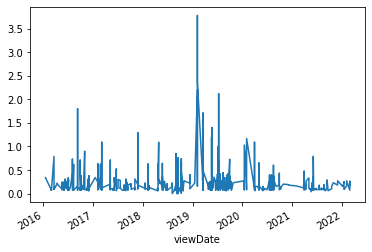

In [95]:
deter_diario_df.loc[deter_diario_df['municipio'] == municipios[0]].sort_values('viewDate').set_index('viewDate')['areaMunKm'].plot()

### Relação diário mensal

Vemos que os avisos mensais, agregados por tipo, são a agregação dos avisos diários.

In [96]:
# Agregamos os tipos de aviso em cada mês num número só:
mensal_agg_df = deter_mensal_df.groupby(['year','month', 'uf'])['area'].sum().reset_index()
# Agregamos os dias e municípios:
diario_agg_df = deter_diario_df.groupby(['year','month', 'uf'])['areaMunKm'].sum()
# Juntamos os dois cálculos:
diario_mensal_comparison = mensal_agg_df.join(diario_agg_df, on=['year', 'month', 'uf'], how='inner')

In [97]:
# Dados que não batem:
diario_mensal_comparison.loc[~np.isclose(diario_mensal_comparison['area'], diario_mensal_comparison['areaMunKm'])]

,year,month,uf,area,areaMunKm


### Cruzamento com registro de GLOs

Alguns municípios estão nos avisos de desmatamento mas não estão na lista de municípios da amazônia legal, construída, se não me engano, com os dados do Prodes de desmatamento por município. Isso ocorre porque esses municípios não estão no [bioma da amazônia](https://amazonia2030.org.br/wp-content/uploads/2021/04/00_Fatos-Amazonia-MAPA-Abre-1-1.jpg).

In [98]:
# Municípios nos avisos mas fora do bioma da amazônia, segundo nossa lista com as GLOs:
set(diario_cleaned_df['municipio'].str.upper().apply(xt.remove_accents) + ' - ' + diario_cleaned_df['uf']) - set(mun_glos_df['Municipio'].str.upper().apply(xt.remove_accents) +  ' - ' + mun_glos_df['Estado'])

{'BURITI BRAVO - MA',
 'CODO - MA',
 'PRESIDENTE VARGAS - MA',
 'SENADOR ALEXANDRE COSTA - MA',
 'VARGEM GRANDE - MA'}

# Lixo

In [18]:
#max_desmate_glo  = max_desmate_in_period(monthly_area_glo_df.loc[monthly_area_glo_df['glo'] == 1], '2019-06-01', '2019-10-01', 'max_desmate_glo')
#max_desmate_ctrl = max_desmate_in_period(monthly_area_glo_df.loc[monthly_area_glo_df['glo'] == 0], '2019-06-01', '2019-10-01', 'max_desmate_ctrl')

### Não usados

In [10]:
# Junta informação de área florestal do município:
mensal_frac_area_df = mensal_cleaned_df.join(mun_glos_area_df.set_index('tag')['Desmatavel'], on='tag')
assert len(mensal_frac_area_df) == len(mensal_cleaned_df)
mensal_frac_area_df['frac_desmatavel'] = mensal_frac_area_df['areaMunKm'] / mensal_frac_area_df['Desmatavel']

### RNN

In [292]:
rnn_glo_df = monthly_area_glo_df.copy()
rnn_glo_df['glo_stage'].fillna('antes', inplace=True)
rnn_glo_df['fase'] = np.abs(8 - rnn_glo_df['month'].dt.month)

rnn_glo_df['durante'] = 0
rnn_glo_df.loc[rnn_glo_df['glo_stage'] == 'durante', 'durante'] = 1
rnn_glo_df['depois'] = 0
rnn_glo_df.loc[rnn_glo_df['glo_stage'] == 'depois', 'depois'] = 1

In [293]:
rnn_features = ['fase', 'areaMunKm', 'durante', 'depois']

In [295]:
rnn_glo_df

,tag,month,areaMunKm,glo,first_glo_month,last_glo_month,glo_stage,fase,durante,depois
0,ABAETETUBA - PA,2016-01-01,0.0,0,NaT,NaT,antes,7,0,0
1,ABAETETUBA - PA,2016-02-01,0.0,0,NaT,NaT,antes,6,0,0
2,ABAETETUBA - PA,2016-03-01,0.0,0,NaT,NaT,antes,5,0,0
3,ABAETETUBA - PA,2016-04-01,0.0,0,NaT,NaT,antes,4,0,0
4,ABAETETUBA - PA,2016-05-01,0.0,0,NaT,NaT,antes,3,0,0
...,...,...,...,...,...,...,...,...,...,...
56995,ZE DOCA - MA,2021-11-01,0.0,1,2020-10-01,2020-10-01,depois,3,0,1
56996,ZE DOCA - MA,2021-12-01,0.0,1,2020-10-01,2020-10-01,depois,4,0,1
56997,ZE DOCA - MA,2022-01-01,0.0,1,2020-10-01,2020-10-01,depois,7,0,1
56998,ZE DOCA - MA,2022-02-01,0.0,1,2020-10-01,2020-10-01,depois,6,0,1


In [294]:
rnn_glo_df[rnn_features].head(20)

,fase,areaMunKm,durante,depois
0,7,0.0,0,0
1,6,0.0,0,0
2,5,0.0,0,0
3,4,0.0,0,0
4,3,0.0,0,0
5,2,0.0,0,0
6,1,0.0,0,0
7,0,0.0,0,0
8,1,0.0,0,0
9,2,0.0,0,0


### Resultado para um Random Forest

In [91]:
dump = classifier.fit(class_X_train, class_y_train)
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(class_X_train)

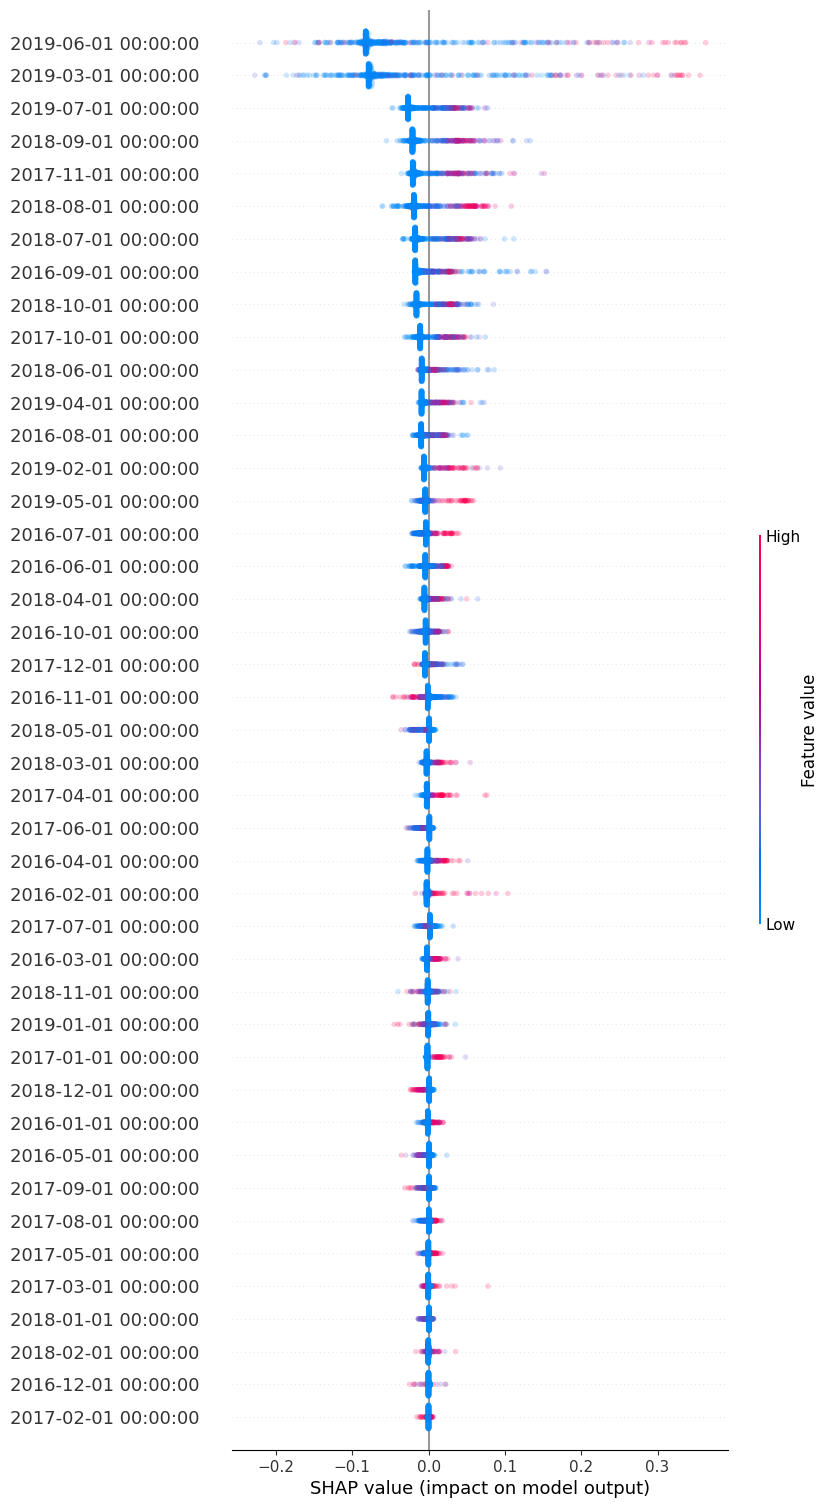

In [61]:
test = copy(shap_values)
test.values = test.values[:, :, 1]
test.base_values = test.base_values[:,1]
test.expected_value = test.base_values[0]
shap.plots.beeswarm(test, max_display=45, alpha=0.2)
pl.show()